In [1]:
### Preprocessing requirements
import pandas as pd
# 1. Copy all .h5 and .mzML files from the job folders to a single output directory for easier access.
# 2. Run the deconvolution to make <filename>_deconvoluted.parquet files.
import os
import numpy as np
from scipy.stats import ttest_ind
# import ztest
from statsmodels.stats.weightstats import ztest
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches


from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist


In [98]:
node_data = annotation_engine.load_envnet_reference(
    graphml_file=os.path.join(ref_dir, "network_with_sirius.graphml"),
    mgf_base_name=os.path.join(ref_dir, "envnet")
)   

Loading ENVnet reference data...
  GraphML file: /global/homes/b/bpb/repos/envnet/results/full_build_20250908_181404/network_with_sirius.graphml
  Deconvoluted MGF: /global/u2/b/bpb/repos/envnet/data//global/homes/b/bpb/repos/envnet/results/full_build_20250908_181404/envnet_deconvoluted_spectra.mgf
  Original MGF: /global/u2/b/bpb/repos/envnet/data//global/homes/b/bpb/repos/envnet/results/full_build_20250908_181404/envnet_original_spectra.mgf
Loaded 22128 ENVnet nodes


In [102]:
PYTHONPATH = "/global/homes/b/bpb/repos/envnet"
if PYTHONPATH not in sys.path:
    sys.path.insert(0, PYTHONPATH)

from envnet.annotation.core import AnnotationEngine
annotation_engine = AnnotationEngine()
ref_dir = '/global/homes/b/bpb/repos/envnet/results/full_build_20250908_181404/'
node_data = annotation_engine.load_envnet_reference(
    graphml_file=os.path.join(ref_dir, "network_with_sirius.graphml"),
    mgf_base_name=os.path.join(ref_dir, "envnet")
)   
cols = ['original_index','precursor_mz','inchi_key', 'compound_name', 'smiles','NPC#pathway', 'NPC#superclass', 'NPC#class','predicted_formula', 'dbe', 'dbe_ai',
       'dbe_ai_mod', 'ai_mod', 'ai', 'nosc', 'h_to_c', 'o_to_c', 'n_to_c',
       'p_to_c', 'c', 'h', 'o', 'n', 's', 'p']
node_data = node_data['nodes'][cols]


model_data = pd.read_csv('../envnet/data/node_data_with_predicted_unchanged.csv')
node_data = node_data.merge(model_data, on='original_index', how='left')

Loading ENVnet reference data...
  GraphML file: /global/homes/b/bpb/repos/envnet/results/full_build_20250908_181404/network_with_sirius.graphml
  Deconvoluted MGF: /global/u2/b/bpb/repos/envnet/data//global/homes/b/bpb/repos/envnet/results/full_build_20250908_181404/envnet_deconvoluted_spectra.mgf
  Original MGF: /global/u2/b/bpb/repos/envnet/data//global/homes/b/bpb/repos/envnet/results/full_build_20250908_181404/envnet_original_spectra.mgf
Loaded 22128 ENVnet nodes


In [3]:

# job_folders = ['egsb/20250415_EB_MdR_109570-002_LigDiv6_20250122_QE119_C18-EP_USDAY92790',
#                'egsb/20231018_EB_MdR_109570-002_WAVEstab_20231017_EXP120A_C18-EP_USDAY72349_vols',
#                'egsb/20240125_EB_MdR_101544-059_WAVESTAB3_20231222_EXP120A_C18-EP_USDAY72349',
#                'jgi/20220707_JGI_SB_503799_Permafrost_pilot_QE-HF_C18_USDAY63663',
#                'jgi/20231004_JGI_SB_503799_Pfrost_final_QEHF_C18_USDAY81384']

# data = []
# output_dir = '/global/cfs/cdirs/metatlas/projects/envnet_build_files/analysis_for_manuscript'
# h5_files = []
# for job_folder in job_folders:
#     full_dir = os.path.join('/global/cfs/cdirs/metatlas/raw_data', job_folder)
#     files = os.listdir(full_dir)
#     files = [f for f in files if '_NEG_' in f]
#     for f in files:
#         if f.endswith('.h5') | f.endswith('.mzML'):
#             old_location = os.path.join(full_dir, f)
#             new_location = os.path.join(output_dir, f)
#             if new_location.endswith('.h5'):
#                 h5_files.append(new_location)
#             # copy to output dir
#             if not os.path.exists(new_location):
#                 os.system(f'cp {old_location} {new_location}')
#             # data.append({'job_folder': job_folder, 'h5': os.path.join(full_dir, f)})

# df = pd.DataFrame(h5_files, columns=['h5'])
# df['parquet'] = df['h5'].str.replace('.h5', '_deconvoluted.parquet')
# df['environmental_subclass'] = 'not applicable'
# df['lcmsrun_observed'] = df['h5'].apply(lambda x: os.path.basename(x).replace('.h5', ''))
# df['original_file_type'] = 'h5'
# output_filename = '/global/homes/b/bpb/repos/envnet/scripts/input_for_ms1-ms2_annotation-experiments-for-paper.csv'
# df.to_csv(output_filename, index=False)
# # 3. For each subfolder run the ms1 and ms2 annotation scripts
# # This is done by making a input.csv for each experiment that looks like this
# # parquet,h5,environmental_subclass,lcmsrun_observed,original_file_type
# # /global/cfs/cdirs/metatlas/projects/envnet_build_files/metatlas/20230223_EB_MdR_101544-059_SynDAC_20230223_QE144_C18-EP_USDAY72350_NEG_MS2_29_RS-HA-NA_1__18_deconvoluted.parquet,/global/cfs/cdirs/metatlas/projects/envnet_build_files/metatlas/20230223_EB_MdR_101544-059_SynDAC_20230223_QE144_C18-EP_USDAY72350_NEG_MS2_29_RS-HA-NA_1__18.h5,Suwannee River Humic Acid Standard III,metatlas/20230223_EB_MdR_101544-059_SynDAC_20230223_QE144_C18-EP_USDAY72350_NEG_MS2_29_RS-HA-NA_1__18,h5
# # /global/cfs/cdirs/metatlas/projects/envnet_build_files/metatlas/20221219_EB_MdR_101544-059_PyrToDAC_20221219_EXP120A_C18-EP_USDAY63672_NEG_MS2_8_FAIII-1mg-NA_1__48_deconvoluted.parquet,/global/cfs/cdirs/metatlas/projects/envnet_build_files/metatlas/20221219_EB_MdR_101544-059_PyrToDAC_20221219_EXP120A_C18-EP_USDAY63672_NEG_MS2_8_FAIII-1mg-NA_1__48.h5,Suwannee River Fulvic Acid Standard III,metatlas/20221219_EB_MdR_101544-059_PyrToDAC_20221219_EXP120A_C18-EP_USDAY63672_NEG_MS2_8_FAIII-1mg-NA_1__48,h5
# #
# # and a ms1 annotation sbatch for each that looks like this for each experiment
# # /global/homes/b/bpb/repos/envnet/scripts/run_env_sample_ms1-annotation.sbatch
# # /global/homes/b/bpb/repos/envnet/scripts/run_env_sample_ms2-annotation.sbatch


In [4]:
ms1_filename = '/pscratch/sd/b/bpb/envnet_annotation_results/ms1_results_experiments_for_paper/ms1_annotations.parquet'
ms2_filename = '/pscratch/sd/b/bpb/envnet_annotation_results/ms2_results_experiments_for_paper/ms2_deconvoluted_annotations.parquet'
ms1_df = pd.read_parquet(ms1_filename)
# get rid of hte 3uL WAVEstab samples
idx1 = ms1_df['lcmsrun_observed'].str.contains('3uL')
idx2 = ms1_df['lcmsrun_observed'].str.contains('WAVEstab')
idx = idx1 & idx2
ms1_df = ms1_df[~idx]

# get rid of the LigDiv6 project samples
idx = ms1_df['lcmsrun_observed'].str.contains('LigDiv6')
ms1_df = ms1_df[~idx]

# get rid of the QC samples
idx = ms1_df['lcmsrun_observed'].str.contains('QC')
ms1_df = ms1_df[~idx]

# get rid of the ctrl samples
idx = ms1_df['lcmsrun_observed'].str.contains('ctrl', case=False)
ms1_df = ms1_df[~idx]

print(ms1_df.shape)
ms2_cols = ['score_deconvoluted_match', 'matches_deconvoluted_match',
       'original_index_deconvoluted_match',  'filename',
        'mz_diff']
ms2_df = pd.read_parquet(ms2_filename, columns=ms2_cols)
ms1_df = pd.merge(ms1_df, ms2_df, left_on=['lcmsrun_observed','original_index'], right_on=['filename','original_index_deconvoluted_match'], how='left')
ms1_df.drop(columns=['original_index_deconvoluted_match','filename','confidence_level','h5'], inplace=True)
ms1_df['has_ms2_evidence'] = pd.notna(ms1_df['score_deconvoluted_match'])
sample_metadata = pd.DataFrame(ms1_df['lcmsrun_observed'].unique(), columns=['lcmsrun_observed'])
sample_metadata['basename'] = sample_metadata['lcmsrun_observed'].apply(lambda x: os.path.basename(x))
sample_metadata['treatment'] = sample_metadata['basename'].apply(lambda x: x.split('_')[12])


print(ms1_df.shape)

(2177809, 10)
(2348663, 12)


In [5]:
idx = sample_metadata['basename'].str.contains('pfrost',case=False)
sample_metadata.loc[idx,'basename'].apply(lambda x: x.split('_')[12])

65     20M-T0-MeOH
66     82M-T1-MeOH
67     66M-T0-MeOH
68     42M-T1-MeOH
69     82M-T1-MeOH
70     66M-T1-MeOH
71     82M-T2-MeOH
72     66M-T2-MeOH
73     42M-T1-MeOH
74     42M-T2-MeOH
75     20M-T0-MeOH
76     20M-T1-MeOH
77     42M-T0-MeOH
78     82M-T0-MeOH
79     55M-T1-MeOH
80     66M-T2-MeOH
81     20M-T1-MeOH
82     66M-T0-MeOH
83     55M-T2-MeOH
84     82M-T1-MeOH
85     55M-T0-MeOH
86     66M-T1-MeOH
87     20M-T1-MeOH
88     82M-T0-MeOH
89     42M-T2-MeOH
90     55M-T0-MeOH
91     20M-T0-MeOH
92     55M-T1-MeOH
93     66M-T1-MeOH
94     55M-T2-MeOH
95     42M-T0-MeOH
96     82M-T2-MeOH
97     20M-T2-MeOH
98     66M-T2-MeOH
99     82M-T0-MeOH
100    55M-T0-MeOH
101    20M-T2-MeOH
102    55M-T2-MeOH
103    42M-T1-MeOH
104    20M-T2-MeOH
105    42M-T2-MeOH
106    55M-T1-MeOH
107    66M-T0-MeOH
108    82M-T2-MeOH
109    42M-T0-MeOH
Name: basename, dtype: object

In [6]:
sample_metadata = pd.DataFrame(ms1_df['lcmsrun_observed'].unique(), columns=['lcmsrun_observed'])
sample_metadata['basename'] = sample_metadata['lcmsrun_observed'].apply(lambda x: os.path.basename(x))
sample_metadata['project'] = sample_metadata['basename'].apply(lambda x: x.split('_')[4])
sample_metadata['treatment'] = sample_metadata['basename'].apply(lambda x: x.split('_')[12])

sample_metadata['timepoint'] = None
idx = sample_metadata['treatment'].str.contains('-d7', regex=False,case=False)
sample_metadata.loc[idx,'timepoint'] = 7
idx = sample_metadata['treatment'].str.contains('-day7', regex=False,case=False)
sample_metadata.loc[idx,'timepoint'] = 7
idx = sample_metadata['treatment'].str.contains('-d0', regex=False,case=False)
sample_metadata.loc[idx,'timepoint'] = 0
idx = sample_metadata['treatment'].str.contains('-day0', regex=False,case=False)
sample_metadata.loc[idx,'timepoint'] = 0
idx = sample_metadata['treatment'].str.contains('-T0-MeOH', regex=False,case=False)
sample_metadata.loc[idx,'timepoint'] = 0
idx = sample_metadata['treatment'].str.contains('-T2-MeOH', regex=False,case=False)
sample_metadata.loc[idx,'timepoint'] = 7

sample_metadata['priming'] = None
idx = sample_metadata['treatment'].str.endswith('-NA')
sample_metadata.loc[idx,'priming'] = 'Unprimed'
idx = sample_metadata['treatment'].str.contains('-na-', regex=False,case=False)
sample_metadata.loc[idx,'priming'] = 'Unprimed'
idx = sample_metadata['treatment'].str.contains('-natcom-salts', regex=False,case=False)
sample_metadata.loc[idx,'priming'] = 'Unprimed'
idx = sample_metadata['treatment'].str.contains('-natcom-nldm', regex=False,case=False)
sample_metadata.loc[idx,'priming'] = 'High'
idx = sample_metadata['treatment'].str.endswith('-Lo')
sample_metadata.loc[idx,'priming'] = 'Low'
idx = sample_metadata['treatment'].str.contains('-0p05xnldm-', regex=False,case=False)
sample_metadata.loc[idx,'priming'] = 'Low'
idx = sample_metadata['treatment'].str.endswith('-Hi')
sample_metadata.loc[idx,'priming'] = 'High'
idx = sample_metadata['treatment'].str.contains('-0p5xnldm-', regex=False,case=False)
sample_metadata.loc[idx,'priming'] = 'High'
idx = sample_metadata['treatment'].str.contains('M-T')
sample_metadata.loc[idx,'priming'] = 'Unprimed'

sample_metadata['soil_type'] = None
idx = sample_metadata['treatment'].str.contains('supern-wave-natcom', regex=False,case=False)
sample_metadata.loc[idx,'soil_type'] = 'Potting Soil'
idx = sample_metadata['treatment'].str.contains('omt1d2', regex=False,case=False)
sample_metadata.loc[idx,'soil_type'] = 'Agricultural Soil'
idx = sample_metadata['treatment'].str.contains('h4171', regex=False,case=False)
sample_metadata.loc[idx,'soil_type'] = 'H4171 lignin'
idx = sample_metadata['treatment'].str.contains('h4161', regex=False,case=False)
sample_metadata.loc[idx,'soil_type'] = 'H4161 lignin'
idx = sample_metadata['treatment'].str.contains('20M-', regex=False,case=False)
sample_metadata.loc[idx,'soil_type'] = '20M permafrost'
idx = sample_metadata['treatment'].str.contains('42M-', regex=False,case=False)
sample_metadata.loc[idx,'soil_type'] = '42M permafrost'
idx = sample_metadata['treatment'].str.contains('55M-', regex=False,case=False)
sample_metadata.loc[idx,'soil_type'] = '55M permafrost'
idx = sample_metadata['treatment'].str.contains('66M-', regex=False,case=False)
sample_metadata.loc[idx,'soil_type'] = '66M permafrost'
idx = sample_metadata['treatment'].str.contains('82M-', regex=False,case=False)
sample_metadata.loc[idx,'soil_type'] = '82M permafrost'

cols = ['timepoint','priming','soil_type']
idx = pd.notna(sample_metadata[cols]).all(axis=1)
sample_metadata = sample_metadata[idx].copy()
sample_metadata.drop(columns=['basename','treatment'], inplace=True)
ms1_df = pd.merge(ms1_df, sample_metadata, on='lcmsrun_observed', how='inner')
idx1 = ms1_df['soil_type'].isin(['Potting Soil','Agricultural Soil'])
idx2 = ms1_df['soil_type'].str.contains('permafrost',case=False)
idx = idx1 | idx2
ms1_df = ms1_df[idx]
print(ms1_df.columns)
print(ms1_df.shape)

Index(['original_index', 'lcmsrun_observed', 'annotation_method',
       'mz_centroid', 'rt_peak', 'peak_height', 'peak_area', 'num_datapoints',
       'score_deconvoluted_match', 'matches_deconvoluted_match', 'mz_diff',
       'has_ms2_evidence', 'project', 'timepoint', 'priming', 'soil_type'],
      dtype='object')
(1861267, 16)


In [21]:
def row_filter(df,project,column_name):
    df = df[~df[column_name].str.contains('exctrl|qc|txctrl',case=False)]
    if project == 'Potting Soil':
        return df[df[column_name].str.contains('6uL') & df[column_name].str.contains('NatCom') & df[column_name].str.contains('Day0|Day7')]
    if project == 'Agricultural Soil NA':
        return df[df[column_name].str.contains('NatCom') & df[column_name].str.contains('NA')]
    if project == 'Agricultural Soil Lo':
        return df[df[column_name].str.contains('NatCom') & df[column_name].str.contains('Lo')]
    if project == 'Agricultural Soil':
        return df[df[column_name].str.contains('NatCom') & df[column_name].str.contains('Hi')]
    elif project == 'soil-ppl':
        return df[df[column_name].str.contains('Run15')]
    # elif project == 'syncom-exudates':
        # return 
    elif project == 'century-exp':
        return df[df[column_name].str.contains('omt|cmt',case=False)]
    else:
        return df
    
def tost(control, treatment, margin=0.25):
    # Perform two one-sided tests.  Note that this
    # is specific for testing if treatment is not
    # the same as control.  If you control mean is
    # near zero this will not work.
    m = np.mean(control)
    lower_margin =  -1*margin*m
    upper_margin = margin*m
    _, p_value_lower = ztest(control, treatment, value=lower_margin, alternative='larger')
    _, p_value_upper = ztest(control, treatment, value=upper_margin, alternative='smaller')
    return max(p_value_lower, p_value_upper)

def do_ttest(df,control_group,treatment_group,do_split=True,min_intensity=1e6,margin=0.2):
    p = pd.pivot_table(df,index=['lcmsrun_observed','timepoint'],values='peak_area',columns='original_index')
    p.fillna(1e5,inplace=True)     
    cols = p.columns
    p.reset_index(inplace=True,drop=False)

    ttest = []
    for c in cols:
        idx1 = p['timepoint']==treatment_group
        idx2 = p['timepoint']==control_group
        treatment = p[c][idx1].values
        control = p[c][idx2].values
        mean_treatment = 1+treatment.mean()
        mean_control = 1+control.mean()
        if (mean_treatment<min_intensity) & (mean_control<min_intensity):
            continue
        fold_change = np.log2(mean_treatment/mean_control)
        t,p_value = ttest_ind(treatment, control)
        # Two One-Sided Tests (TOST) procedure using 50% margin
        p_tost = tost(control,treatment, margin=0.5)
        ttest.append({'original_index':c,'t':t,'p':p_value,'fc':fold_change,'tost':p_tost,
                      'mean_treatment':mean_treatment,'mean_control':mean_control,
                      'treatment_vals':treatment,
                      'control_vals':control})
    ttest = pd.DataFrame(ttest)
    return ttest

def create_volcano_plot(plot_df, ax, title):
    """Creates a single volcano plot with clipped fold change."""
    plot_df = plot_df.copy()
    
    # Clip fold change to -8 to 8
    plot_df['fc'] = plot_df['fc'].clip(-5, 5)
    
    plot_df['-log10_p'] = -np.log10(plot_df['p'].clip(lower=1e-8))

    for classification, color in CLASSIFICATION_COLORS.items():
        subset = plot_df[plot_df['classification'] == classification]
        if not subset.empty:
            ax.scatter(subset['fc'], subset['-log10_p'], c=color, alpha=1, s=35,
                       label=classification, edgecolors='white', linewidth=0.5)

    unclassified = plot_df[plot_df['classification'].isna()]
    if not unclassified.empty:
        ax.scatter(unclassified['fc'], unclassified['-log10_p'], c=UNCLASSIFIED_COLOR,
                   alpha=1, s=35, label='Unclassified', edgecolors='white', linewidth=0.3)

    ax.axhline(y=-np.log10(0.05), color='black', linestyle='--', alpha=0.7, linewidth=1.2)
    ax.axvline(x=0.5, color='black', linestyle='--', alpha=0.7, linewidth=1.2)
    ax.axvline(x=-0.5, color='black', linestyle='--', alpha=0.7, linewidth=1.2)

    # Set x-axis limits to -8 to 8
    ax.set_xlim(-5.1, 5.1)
    
    ax.set_xlabel('Log₂ Fold Change', fontsize=30)
    ax.set_ylabel('-Log₁₀(p-value)', fontsize=30)
    ax.set_title(title, fontsize=20, pad=5)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
    ax.tick_params(axis='both', which='major', labelsize=20)

def truncate_class_names(class_names, max_length=35):
    """Truncates long compound class names."""
    return [str(name)[:max_length-3] + '...' if len(str(name)) > max_length else str(name) for name in class_names]


def get_combined_class_order(df, node_data, min_compounds):
    """Gets a consistent order of compound classes using hierarchical clustering.
    Only includes classes that have at least min_compounds in EVERY condition."""
    
    # First pass: count compounds per class per condition
    class_counts_by_condition = {}
    all_classes = set()
    
    for cond_idx, cond in enumerate(CONDITIONS):
        idx = (df['soil_type'] == cond['soil_type'])
        if cond['priming'] is not None:
            idx &= (df['priming'] == cond['priming'])
        plot_df = df[idx]
        plot_df = pd.merge(plot_df, node_data, on='original_index', how='left')
        
        class_counts = plot_df.groupby(compound_class_col)['classification'].count()
        class_counts_by_condition[cond_idx] = class_counts.to_dict()
        all_classes.update(class_counts.keys())
    
    # Filter to classes that have min_compounds in EVERY condition
    abundant_classes = []
    for class_name in all_classes:
        meets_threshold = True
        for cond_idx in range(len(CONDITIONS)):
            count = class_counts_by_condition[cond_idx].get(class_name, 0)
            if count < min_compounds:
                meets_threshold = False
                break
        if meets_threshold:
            abundant_classes.append(class_name)
    
    if len(abundant_classes) <= 1:
        return abundant_classes
    
    # Initialize feature matrix: rows = classes, columns = conditions × classifications
    n_classes = len(abundant_classes)
    n_features = len(CONDITIONS) * 3  # 3 classifications per condition
    feature_matrix = np.zeros((n_classes, n_features))
    
    # Build feature vectors
    class_to_idx = {cls: i for i, cls in enumerate(abundant_classes)}
    
    for cond_idx, cond in enumerate(CONDITIONS):
        idx = (df['soil_type'] == cond['soil_type'])
        if cond['priming'] is not None:
            idx &= (df['priming'] == cond['priming'])
        plot_df = df[idx]
        plot_df = pd.merge(plot_df, node_data, on='original_index', how='left')
        
        for class_name in abundant_classes:
            class_subset = plot_df[plot_df[compound_class_col] == class_name]
            total = len(class_subset)
            
            if total > 0:
                produced_pct = len(class_subset[class_subset['classification'] == 'enriched']) / total
                prefered_pct = len(class_subset[class_subset['classification'] == 'depleted']) / total
                ignored_pct = len(class_subset[class_subset['classification'] == 'unchanged']) / total
            else:
                produced_pct, prefered_pct, ignored_pct = 0, 0, 0
            
            row_idx = class_to_idx[class_name]
            col_offset = cond_idx * 3
            feature_matrix[row_idx, col_offset] = produced_pct
            feature_matrix[row_idx, col_offset + 1] = prefered_pct
            feature_matrix[row_idx, col_offset + 2] = ignored_pct
    
    # Perform hierarchical clustering
    linkage_matrix = linkage(feature_matrix, method='ward')
    
    # Get the order from the dendrogram
    dend = dendrogram(linkage_matrix, no_plot=True)
    cluster_order = dend['leaves']
    
    # Return classes in clustered order
    return [abundant_classes[i] for i in cluster_order]

def prepare_barchart_data(df, global_class_order):
    """Prepares and normalizes data for a single stacked bar chart."""
    temp = df.groupby(compound_class_col)['classification'].value_counts().unstack(fill_value=0)
    for col in CLASSIFICATION_COLORS:
        if col not in temp.columns:
            temp[col] = 0
    temp = temp[list(CLASSIFICATION_COLORS.keys())]
    temp = temp.div(temp.sum(axis=1), axis=0)
    temp = temp.reindex(global_class_order).dropna()
    return temp

In [8]:
grouped_ms1_df = [g for _, g in ms1_df.groupby(['project','priming','soil_type'])]
print(len(grouped_ms1_df))
out = []
for g_df in grouped_ms1_df:
    project = g_df['project'].values[0]
    priming = g_df['priming'].values[0]
    soil_type = g_df['soil_type'].values[0]
    print(f'Processing {project} {priming} {soil_type}')
    ttest = do_ttest(g_df,0,7,min_intensity=1e7)
    ttest['project'] = project
    ttest['priming'] = priming
    ttest['soil_type'] = soil_type
    idx_prefered = (ttest['fc']<-0.5) & (ttest['p']<0.05)
    idx_produced = (ttest['fc']>0.5) & (ttest['p']<0.05)
    idx_ignored = ttest['tost']<0.05
    ttest['classification'] = None
    ttest.loc[idx_ignored,'classification'] = 'unchanged'
    # overwrite any that are overlapping, prioritize prefered and produced
    ttest.loc[idx_prefered,'classification'] = 'depleted'
    ttest.loc[idx_produced,'classification'] = 'enriched'
    out.append(ttest)
final_df = pd.concat(out, ignore_index=True)

# merge in ms2 evidence at the project/soil_type level
cols = ['has_ms2_evidence', 'original_index', 'project', 'soil_type','priming']
ms2_evidence = ms1_df[cols].drop_duplicates(subset=cols[1:])
final_df = pd.merge(final_df, ms2_evidence, on=cols[1:], how='left')
final_df.to_csv('training data for stability model 20251106.csv', index=False)
print(final_df.columns)
print(final_df.shape)

10
Processing Pfrost Unprimed 20M permafrost
Processing Pfrost Unprimed 42M permafrost
Processing Pfrost Unprimed 55M permafrost


/tmp/ipykernel_826995/1740582831.py:49: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t,p_value = ttest_ind(treatment, control)


Processing Pfrost Unprimed 66M permafrost
Processing Pfrost Unprimed 82M permafrost
Processing WAVESTAB3 High Agricultural Soil


/tmp/ipykernel_826995/1740582831.py:49: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t,p_value = ttest_ind(treatment, control)


Processing WAVESTAB3 Low Agricultural Soil


/tmp/ipykernel_826995/1740582831.py:49: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t,p_value = ttest_ind(treatment, control)


Processing WAVESTAB3 Unprimed Agricultural Soil


/tmp/ipykernel_826995/1740582831.py:49: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t,p_value = ttest_ind(treatment, control)


Processing WAVEstab High Potting Soil


/tmp/ipykernel_826995/1740582831.py:49: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t,p_value = ttest_ind(treatment, control)


Processing WAVEstab Unprimed Potting Soil


/tmp/ipykernel_826995/1740582831.py:49: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t,p_value = ttest_ind(treatment, control)


Index(['original_index', 't', 'p', 'fc', 'tost', 'mean_treatment',
       'mean_control', 'treatment_vals', 'control_vals', 'project', 'priming',
       'soil_type', 'classification', 'has_ms2_evidence'],
      dtype='object')
(123275, 14)


In [12]:
final_df[['soil_type','classification','priming']].value_counts()

soil_type          classification  priming 
Agricultural Soil  unchanged       Unprimed    14476
                                   Low         13997
                                   High        12421
Potting Soil       unchanged       Unprimed    11461
55M permafrost     depleted        Unprimed     7838
66M permafrost     unchanged       Unprimed     7527
Potting Soil       depleted        High         7300
                   unchanged       High         4993
42M permafrost     unchanged       Unprimed     4624
20M permafrost     unchanged       Unprimed     1877
Agricultural Soil  enriched        High         1717
                   depleted        High         1650
82M permafrost     unchanged       Unprimed     1550
Potting Soil       depleted        Unprimed     1298
Agricultural Soil  depleted        Low          1060
                   enriched        Low           896
                                   Unprimed      697
                   depleted        Unprimed      478
Po

In [53]:
temp = p[unchanged_all].copy()
temp = temp.loc[pd.notna(temp[c]),c].value_counts()
temp['condition'] = c
# temp = temp.value_counts()
temp

unchanged                        356
enriched                          18
depleted                          13
condition    82M permafrost_Unprimed
Name: 82M permafrost_Unprimed, dtype: object

In [69]:
p['66M permafrost_Unprimed'].value_counts()

unchanged    7527
enriched       55
depleted       29
Name: 66M permafrost_Unprimed, dtype: int64

In [ ]:
p = pd.pivot_table(final_df,columns=['soil_type','priming'],index='original_index',values='classification',fill_value=None,aggfunc='first')
p.columns = ['_'.join([str(c) for c in col]).strip() for col in p.columns.values]
my_class = 'depleted'
idx1 = ((p==my_class) | (p.isna())).sum(axis=1)==10
idx2 = (p==my_class).sum(axis=1)>=4
idx = idx1 & idx2
node_data.loc[node_data['original_index'].isin(p[idx].index),'NPC#class'].value_counts().head(20)
node_data[node_data['original_index'].isin(p[idx].index)]


,original_index,precursor_mz,inchi_key,compound_name,smiles,NPC#pathway,NPC#superclass,NPC#class,predicted_formula,dbe,...,n_to_c,p_to_c,c,h,o,n,s,p,predicted_unchanged_in_soil,predicted_unchanged_in_soil_prob
62,593490,221.029554,NaN,NaN,NaN,Carbohydrates,Saccharides,Monosaccharides,C7H10O8,3.0,...,0.0,0.0,7.0,10.0,8.0,0.0,0.0,0.0,0,0.002008
2665,1494388,299.01958,NaN,NaN,NaN,Polyketides,Polycyclic aromatic polyketides,Anthraquinones and anthrones,C15H8O7,12.0,...,0.0,0.0,15.0,8.0,7.0,0.0,0.0,0.0,0,0.028238
2723,1494308,299.019479,NaN,NaN,NaN,Polyketides,Polycyclic aromatic polyketides,Anthraquinones and anthrones,C15H8O7,12.0,...,0.0,0.0,15.0,8.0,7.0,0.0,0.0,0.0,0,0.036884
5409,3889069,413.01478,NaN,NaN,NaN,Shikimates and Phenylpropanoids,Phenolic acids (C6-C1),Gallotannins,C19H10O11,15.0,...,0.0,0.0,19.0,10.0,11.0,0.0,0.0,0.0,0,0.278651
13789,1791611,315.014356,NaN,NaN,NaN,Shikimates and Phenylpropanoids,Phenolic acids (C6-C1),Gallotannins,C15H8O8,12.0,...,0.0,0.0,15.0,8.0,8.0,0.0,0.0,0.0,0,0.018059
17013,1494609,299.020664,NaN,NaN,NaN,Amino acids and Peptides,Small peptides,Aminoacids,C16H12O2S2,11.0,...,0.0,0.0,16.0,12.0,2.0,0.0,2.0,0.0,0,0.037851
17107,1494799,299.022626,NaN,NaN,NaN,Polyketides,Aromatic polyketides,Simple phenolic acids,C12H12O7S,7.0,...,0.0,0.0,12.0,12.0,7.0,0.0,1.0,0.0,0,0.069346
18201,1494005,299.016765,NaN,NaN,NaN,Amino acids and Peptides,Small peptides,Aminoacids,C11H12N2O4S2,7.0,...,0.181818,0.0,11.0,12.0,4.0,2.0,2.0,0.0,0,0.047323
18202,1493995,299.016732,NaN,NaN,NaN,Alkaloids,Anthranilic acid alkaloids,Anthranillic acid derivatives,C11H12N2O4S2,7.0,...,0.181818,0.0,11.0,12.0,4.0,2.0,2.0,0.0,0,0.020107
18203,1494117,299.017407,NaN,NaN,NaN,Fatty acids,Fatty acyls,Oxygenated hydrocarbons,C8H13O10P,2.5,...,0.0,0.125,8.0,13.0,10.0,0.0,0.0,1.0,0,0.026266


In [56]:
p = pd.pivot_table(final_df,columns=['soil_type','priming'],index='original_index',values='classification',fill_value=None,aggfunc='first')
p.columns = ['_'.join([str(c) for c in col]).strip() for col in p.columns.values]
p.reset_index(inplace=True,drop=False)
soil_cols = [c for c in p.columns if 'Soil' in c]
unchanged_all = p[soil_cols].apply(lambda row: all(row == 'unchanged'), axis=1)
pfrost_cols  = [c for c in p.columns if 'permafrost' in c]
out = []
out_all = []
for c in pfrost_cols:
    # for unchanged in pfrost sample, check if unchanged in soil samples
    temp = p[unchanged_all].copy()
    print(p.shape,temp.shape)
    temp = temp.loc[pd.notna(temp[c]),c].value_counts()
    temp['condition'] = c
    out.append(temp)
    temp = p.copy()
    print(p.shape,temp.shape)
    temp = temp.loc[pd.notna(temp[c]),c].value_counts()
    temp['condition'] = c
    out_all.append(temp)
df_unchanged = pd.DataFrame(out)
df_all = pd.DataFrame(out_all)
df_summary = df_unchanged.merge(df_all, on='condition', suffixes=('_unchanged','_all'))
df_summary

(18087, 11) (3490, 11)
(18087, 11) (18087, 11)
(18087, 11) (3490, 11)
(18087, 11) (18087, 11)
(18087, 11) (3490, 11)
(18087, 11) (18087, 11)
(18087, 11) (3490, 11)
(18087, 11) (18087, 11)
(18087, 11) (3490, 11)
(18087, 11) (18087, 11)


,unchanged_unchanged,enriched_unchanged,depleted_unchanged,condition,unchanged_all,depleted_all,enriched_all
0,523,6.0,5,20M permafrost_Unprimed,1877,42,9
1,2004,NaN,13,42M permafrost_Unprimed,4624,37,3
2,7,3.0,2154,55M permafrost_Unprimed,38,7838,10
3,2755,3.0,1,66M permafrost_Unprimed,7527,29,55
4,356,18.0,13,82M permafrost_Unprimed,1550,24,65


In [72]:
from scipy.spatial.distance import pdist, squareform

import numpy as np
from multiprocessing import Pool
from itertools import combinations

import numpy as np

def pairwise_available_euclidean_vectorized(X):
    n, m = X.shape
    
    # Expand dimensions for broadcasting: (n, 1, m) and (1, n, m)
    X1 = X[:, np.newaxis, :]  # shape (n, 1, m)
    X2 = X[np.newaxis, :, :]  # shape (1, n, m)
    
    # Mask for valid (non-NaN) pairs
    valid_mask = ~(np.isnan(X1) | np.isnan(X2))  # shape (n, n, m)
    
    # Squared differences (NaNs will be ignored)
    diff_sq = np.where(valid_mask, (X1 - X2)**2, 0)  # shape (n, n, m)
    
    # Count valid dimensions for each pair
    count = valid_mask.sum(axis=2)  # shape (n, n)
    
    # Sum of squared differences
    sum_sq = diff_sq.sum(axis=2)  # shape (n, n)
    
    # Mean squared difference, then sqrt
    # Avoid division by zero
    D = np.sqrt(np.divide(sum_sq, count, out=np.zeros_like(sum_sq), where=count>0))
    
    return D

# Usage
# final_df['numerical_classification'] = final_df['classification'].replace({'enriched':2,'depleted':-2,'unchanged':0})
# p = pd.pivot_table(final_df,columns=['soil_type','priming'],index='original_index',values='numerical_classification',fill_value=None)
p = pd.pivot_table(final_df[final_df['has_ms2_evidence']==True],columns=['soil_type','priming'],index='original_index',values='fc',fill_value=None)

sum_valid = p.notna().sum(axis=1)
p = p[sum_valid>=2]
print(p.shape)
# p = p.sample(frac=0.1, random_state=42)  # for testing purposes, use a subset
distance_matrix = pairwise_available_euclidean_vectorized(p.values)
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.manifold import TSNE

# 2. Hierarchical clustering
linkage_matrix = linkage(distance_matrix[np.triu_indices(len(distance_matrix), k=1)], method='ward')

# 3. Get cluster labels (adjust t for number of clusters you want)
clusters = fcluster(linkage_matrix, t=5, criterion='maxclust')

# 4. t-SNE projection
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
coords = tsne.fit_transform(distance_matrix)

(1035, 5)


In [63]:
# --- Common Setup and Data Loading ---
# This part is run only once to load and prepare the data.
data_path = '../results/full_build_20250908_181404/permafrost results gnps2'
analysis_filename = os.path.join(data_path, 'analysis_results', 'statistical_results.csv')

# Load the data
output = pd.read_csv(analysis_filename)
output

,original_index,mean-20M,mean-55M,median-20M,median-55M,standard_error-20M,standard_error-55M,std_dev-20M,std_dev-55M,p_value,t_score,log2_foldchange,peak_values_normalized,peak_value_used,control_group,treatment_group
0,1001604,1.729145e+07,7.307282e+05,1.710544e+07,9.489428e+05,6.726798e+05,246888.348758,1.165116e+06,427623.163845,0.000021,23.111568,-4.564578,True,peak_area,20M,55M
1,1002088,1.329859e+06,1.240704e+06,1.109054e+06,9.956272e+05,3.027558e+05,406646.629831,5.243885e+05,704332.623594,0.868950,0.175857,-0.100114,True,peak_area,20M,55M
2,1002162,1.329859e+06,1.246314e+06,1.109054e+06,1.009815e+06,3.027558e+05,404644.982413,5.243885e+05,700865.668567,0.876716,0.165314,-0.093605,True,peak_area,20M,55M
3,100228,6.753014e+05,2.052755e+05,7.087981e+05,2.109708e+05,3.824422e+04,40801.297764,6.624093e+04,70669.920743,0.001097,8.404897,-1.717965,True,peak_area,20M,55M
4,1002548,0.000000e+00,5.747172e+03,0.000000e+00,0.000000e+00,0.000000e+00,5747.171660,0.000000e+00,9954.393315,0.373901,-1.000000,12.488887,True,peak_area,20M,55M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21124,994747,5.669733e+05,6.179534e+03,5.825529e+05,0.000000e+00,4.246022e+04,6179.533745,7.354325e+04,10703.266413,0.000198,13.069820,-6.519408,True,peak_area,20M,55M
21125,99542,3.567469e+05,0.000000e+00,4.245465e+05,0.000000e+00,8.304872e+04,0.000000,1.438446e+05,0.000000,0.012689,4.295634,-18.444546,True,peak_area,20M,55M
21126,99642,1.568343e+05,9.277738e+04,1.200234e+05,7.702345e+04,6.598219e+04,19148.700058,1.142845e+05,33166.521399,0.403934,0.932352,-0.757389,True,peak_area,20M,55M
21127,997643,3.005822e+05,2.493697e+04,2.856274e+05,0.000000e+00,5.904210e+04,24936.970753,1.022639e+05,43192.100332,0.012638,4.300755,-3.591349,True,peak_area,20M,55M


Plotting Agricultural Soil High with 1035 points
Plotting Agricultural Soil Low with 1035 points
Plotting Agricultural Soil Unprimed with 1035 points
Plotting Potting Soil High with 1035 points
Plotting Potting Soil Unprimed with 1035 points


/tmp/ipykernel_1082004/476517237.py:20: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  subset = pd.merge(subset,p, left_on='original_index', right_index=True, how='right')
/tmp/ipykernel_1082004/476517237.py:20: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  subset = pd.merge(subset,p, left_on='original_index', right_index=True, how='right')
/tmp/ipykernel_1082004/476517237.py:20: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  subset = pd.merge(subset,p, left_on='original_index', right_index=True, how='right')
/tmp/ipykernel_1082004/476517237.py:20: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  subset = 

(-40.174184036254886, 46.919049453735354)

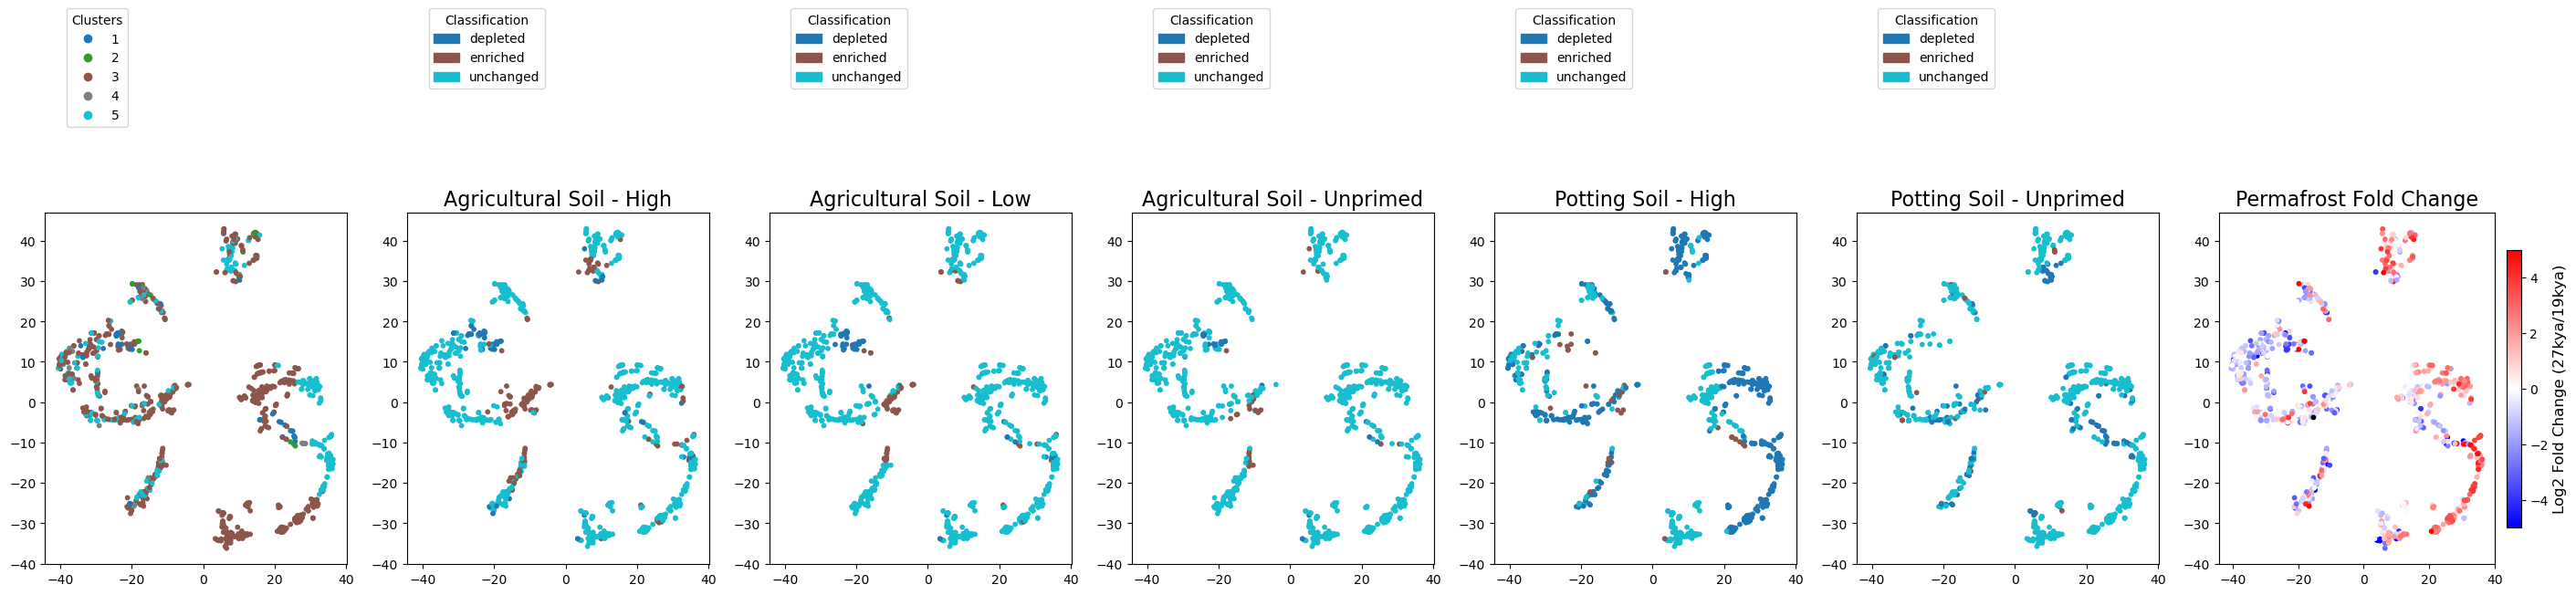

In [73]:


# 5. Plot with cluster colors
fig,ax = plt.subplots(nrows=1,ncols=7, figsize=(35,5))

scatter = ax[0].scatter(coords[:, 0], coords[:, 1], 
                     c=clusters, cmap='tab10', 
                     alpha=1, s=10 )
legend1 = ax[0].legend(*scatter.legend_elements(), title="Clusters", bbox_to_anchor=(0.05, 1.6), loc='upper left')
# get full x y limits to use in the other plots
x_limits = ax[0].get_xlim()
y_limits = ax[0].get_ylim()
# ax[0].add_artist(legend1)
# get uniqe soils and priming and make plots for each
soil_priming_combinations = final_df[['soil_type','priming']].drop_duplicates().values
counter = 1
for i,(soil_type, priming) in enumerate(soil_priming_combinations):
    idx = (final_df['soil_type']==soil_type) & (final_df['priming']==priming)
    subset = final_df[idx].copy()
    subset = subset[subset['original_index'].isin(p.index)]
    # align subset order to p index
    subset = pd.merge(subset,p, left_on='original_index', right_index=True, how='right')
    print(f'Plotting {soil_type} {priming} with {subset.shape[0]} points')
    idx = subset['classification'].notna()
    color_values = subset.loc[idx, 'classification']
    # convert to categorical colors
    categorical_colors = pd.Categorical(color_values).codes
    scatter = ax[counter].scatter(coords[idx, 0], coords[idx, 1], 
                     c=categorical_colors, cmap='tab10',
                     alpha=1, s=10 )
    ax[counter].set_title(f'{soil_type} - {priming}', fontsize=16)
    # the legend should use color values as labels
    labels = pd.Categorical(color_values).categories
    handles = [mpatches.Patch(color=scatter.cmap(scatter.norm(i)), label=label) for i, label in enumerate(labels)]
    ax[counter].legend(handles=handles, title="Classification", bbox_to_anchor=(0.05, 1.6), loc='upper left')
    ax[counter].set_xlim(x_limits)
    ax[counter].set_ylim(y_limits)
    counter = counter + 1

pfrost_data = output[output['original_index'].isin(p.index)].copy()
# order the original index to match p index
pfrost_data = pd.merge(pfrost_data,p, left_on='original_index', right_index=True, how='right')
# plot pfrost points colored by log2 fold change
color_values = pfrost_data['log2_foldchange']
# convert to categorical colors
norm = plt.Normalize(vmin=-5, vmax=5)
cmap = plt.get_cmap('bwr')
colors = cmap(norm(color_values))
scatter = ax[counter].scatter(coords[:, 0], coords[:, 1], 
                     c=colors, 
                     alpha=1, s=10 )
ax[counter].set_title(f'Permafrost Fold Change', fontsize=16)
# create a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax[counter], fraction=0.046, pad=0.04)
cbar.set_label('Log2 Fold Change (27kya/19kya)', fontsize=12)
ax[counter].set_xlim(x_limits)
ax[counter].set_ylim(y_limits)

In [112]:
node_data.columns

Index(['original_index', 'precursor_mz', 'inchi_key', 'compound_name',
       'smiles', 'NPC#pathway', 'NPC#superclass', 'NPC#class',
       'predicted_formula', 'dbe', 'dbe_ai', 'dbe_ai_mod', 'ai_mod', 'ai',
       'nosc', 'h_to_c', 'o_to_c', 'n_to_c', 'p_to_c', 'c', 'h', 'o', 'n', 's',
       'p', 'predicted_unchanged_in_soil', 'predicted_unchanged_in_soil_prob'],
      dtype='object')

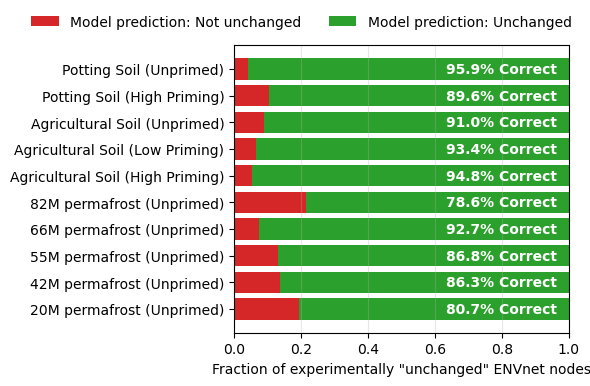

In [156]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for stacked bar chart
bar_data = []

for soil_type in final_df['soil_type'].unique():
    df_soil = final_df[final_df['soil_type']==soil_type].copy()
    for priming in df_soil['priming'].unique():
        df_subset = df_soil[df_soil['priming']==priming]
        nodes = df_subset[(df_subset['classification']=='unchanged')]['original_index'].tolist()
        
        # Get the probability values
        prob_values = node_data[node_data['original_index'].isin(nodes)]['predicted_unchanged_in_soil_prob']
        
        # Count True (>=0.5) and False (<0.5)
        true_count = (prob_values >= 0.5).sum()
        false_count = (prob_values < 0.5).sum()
        total = len(prob_values)
        
        # Store data
        bar_data.append({
            'label': f'{soil_type} {priming}',
            'true': true_count,
            'false': false_count,
            'total': total,
            'true_prop': true_count / total if total > 0 else 0,
            'false_prop': false_count / total if total > 0 else 0
        })

# Create the normalized stacked horizontal bar chart
fig, ax = plt.subplots(figsize=(6, 4))

labels = []
for d in bar_data:
    if 'Unprimed' in d['label']:
        label = d['label'].replace(' Unprimed', ' (Unprimed)')
    elif 'Low' in d['label']:
        label = d['label'].replace(' Low', ' (Low Priming)')
    elif 'High' in d['label']:
        label = d['label'].replace(' High', ' (High Priming)')
    labels.append(label)

false_props = [d['false_prop'] for d in bar_data]
true_props = [d['true_prop'] for d in bar_data]

y_pos = np.arange(len(labels))

# Create horizontal stacked bars
ax.barh(y_pos, false_props, label='Model prediction: Not unchanged', color='#d62728')
ax.barh(y_pos, true_props, left=false_props, label='Model prediction: Unchanged', color='#2ca02c')

# Add text annotations showing true/total fraction
for i, d in enumerate(bar_data):
    # Position text in the middle of the bar
    x_pos = 0.8
    val = d['true']/d['total']
    val = val*100
    ax.text(x_pos, i, f"{val:.1f}% Correct", color='white',
            ha='center', va='center', fontweight='bold', fontsize=10)

# Customize the plot
ax.set_yticks(y_pos)
ax.set_yticklabels(labels)
ax.set_xlabel('Fraction of experimentally "unchanged" ENVnet nodes')
ax.set_xlim(0, 1)
# locate legend above the plot
ax.legend(loc='upper center', bbox_to_anchor=(0.2, 1.15), ncol=2,frameon=False)#, title='Prediction')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

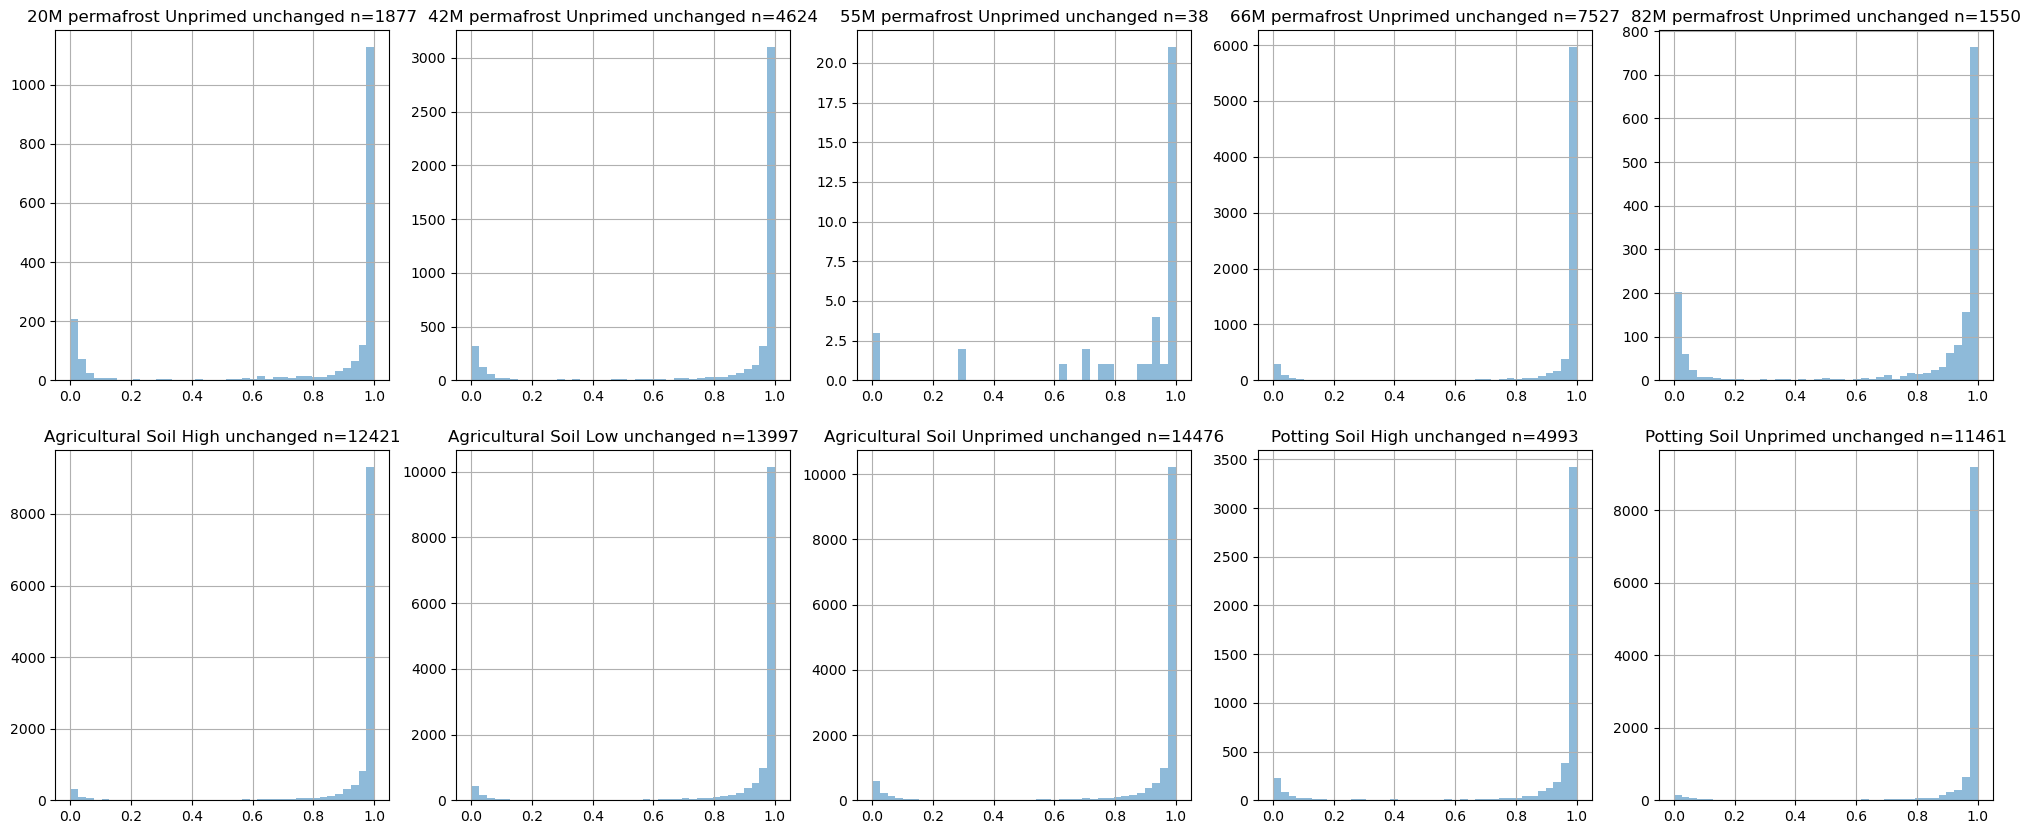

In [ ]:
fig,ax = plt.subplots(nrows=2,ncols=5, figsize=(25,10))
ax = ax.flatten()

counter = 0
for soil_type in final_df['soil_type'].unique():
    df55 = final_df[final_df['soil_type']==soil_type].copy()
    for priming in df55['priming'].unique():
        df55_primed = df55[df55['priming']==priming]
        nodes55 = df55_primed[(df55_primed['classification']=='unchanged')]['original_index'].tolist()
        edges = np.linspace(0,1,40)
        node_data[node_data['original_index'].isin(nodes55)]['predicted_unchanged_in_soil_prob'].hist(bins=edges,label=f'{soil_type} {priming} unchanged', alpha=0.5,ax=ax[counter])
        ax[counter].set_title(f'{soil_type} {priming} unchanged n={len(nodes55)}')
        counter += 1
    

Displaying 17 most abundant compound classes.
{'soil_type': 'Agricultural Soil', 'priming': 'Unprimed', 'title': 'Agricultural Soil\nUnprimed'} 16595
{'soil_type': 'Agricultural Soil', 'priming': 'Low', 'title': 'Agricultural Soil\nLow Priming'} 16646
{'soil_type': 'Agricultural Soil', 'priming': 'High', 'title': 'Agricultural Soil\nHigh Priming'} 16656
{'soil_type': 'Potting Soil', 'priming': 'Unprimed', 'title': 'Potting Soil\nUnprimed'} 13325
{'soil_type': 'Potting Soil', 'priming': 'High', 'title': 'Potting Soil\nHigh Priming'} 12965
{'soil_type': '20M permafrost', 'priming': 'Unprimed', 'title': '20M permafrost\nUnprimed'} 2120
{'soil_type': '42M permafrost', 'priming': 'Unprimed', 'title': '42M permafrost\nUnprimed'} 8965
{'soil_type': '55M permafrost', 'priming': 'Unprimed', 'title': '55M permafrost\nUnprimed'} 13257
{'soil_type': '66M permafrost', 'priming': 'Unprimed', 'title': '66M permafrost\nUnprimed'} 11319
{'soil_type': '82M permafrost', 'priming': 'Unprimed', 'title': '8

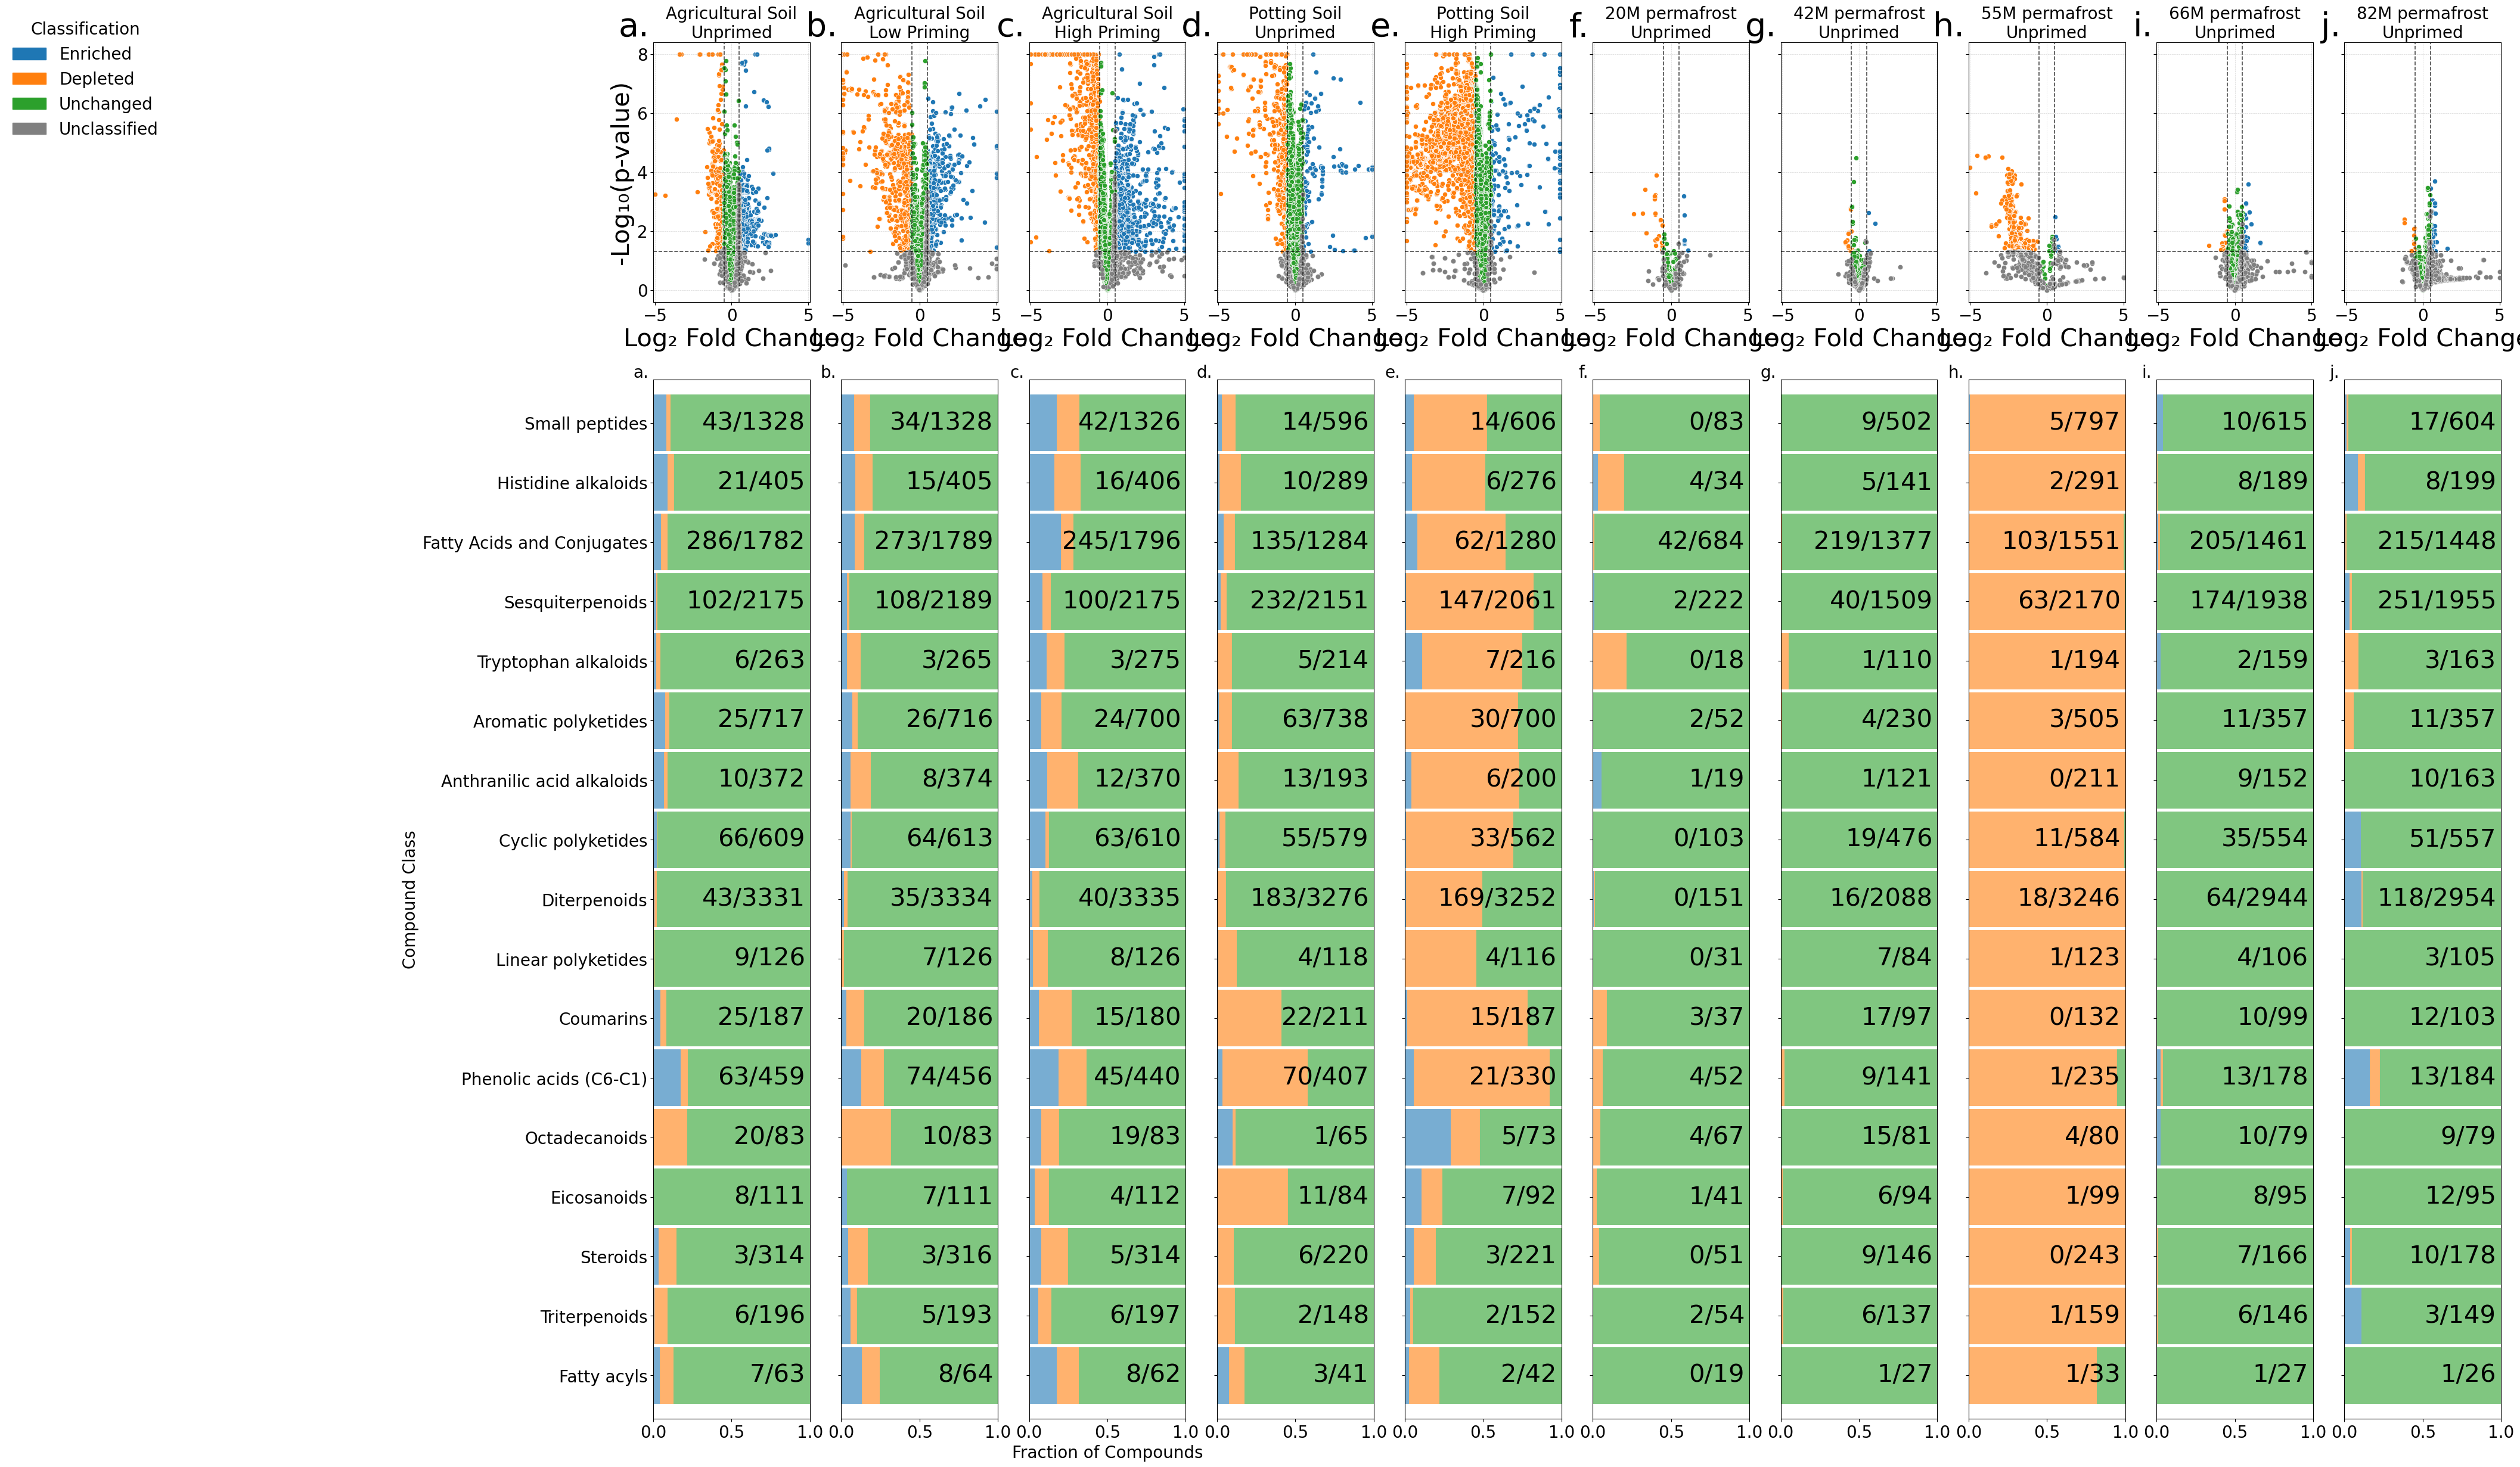

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Assume final_df and node_data are pre-loaded DataFrames
UNCLASSIFIED_COLOR = 'gray'
# --- Configuration Section ---
CLASSIFICATION_COLORS = {
    'enriched': '#1f77b4',
    'depleted': '#ff7f0e',
    'unchanged': '#2ca02c',
    'unclassified': UNCLASSIFIED_COLOR
}


MIN_COMPOUNDS_FOR_DISPLAY = 10

CONDITIONS = [
    {'soil_type': 'Agricultural Soil', 'priming': 'Unprimed', 'title': 'Agricultural Soil\nUnprimed'},
    {'soil_type': 'Agricultural Soil', 'priming': 'Low',      'title': 'Agricultural Soil\nLow Priming'},
    {'soil_type': 'Agricultural Soil', 'priming': 'High',     'title': 'Agricultural Soil\nHigh Priming'},
    {'soil_type': 'Potting Soil',      'priming': 'Unprimed',       'title': 'Potting Soil\nUnprimed'},
    {'soil_type': 'Potting Soil',      'priming': 'High',       'title': 'Potting Soil\nHigh Priming'},
    {'soil_type': '20M permafrost',      'priming': 'Unprimed',       'title': '20M permafrost\nUnprimed'},
    {'soil_type': '42M permafrost',      'priming': 'Unprimed',       'title': '42M permafrost\nUnprimed'},
    {'soil_type': '55M permafrost',      'priming': 'Unprimed',       'title': '55M permafrost\nUnprimed'},
    {'soil_type': '66M permafrost',      'priming': 'Unprimed',       'title': '66M permafrost\nUnprimed'},
    {'soil_type': '82M permafrost',      'priming': 'Unprimed',       'title': '82M permafrost\nUnprimed'},

]
# sample_metadata.loc[idx,'soil_type'] = '20M permafrost'
# idx = sample_metadata['treatment'].str.contains('42M-', regex=False,case=False)
# sample_metadata.loc[idx,'soil_type'] = '42M permafrost'
# idx = sample_metadata['treatment'].str.contains('55M-', regex=False,case=False)
# sample_metadata.loc[idx,'soil_type'] = '55M permafrost'
# idx = sample_metadata['treatment'].str.contains('66M-', regex=False,case=False)
# sample_metadata.loc[idx,'soil_type'] = '66M permafrost'
# idx = sample_metadata['treatment'].str.contains('82M-', regex=False,case=False)
# sample_metadata.loc[idx,'soil_type'] = '82M permafrost'

compound_class_col = 'NPC#superclass'

# --- Helper Functions ---

def add_ms2_count_labels_v2(ax, ms2_counts, ms1_counts, soil_type, priming, bar_data, x_offset=0.02, fontsize=12):
    """
    Add MS2 count labels using the bar_data index directly.
    """
    for i, compound_class in enumerate(bar_data.index):
        try:
            count = ms2_counts.loc[compound_class, (soil_type, priming)]
            count_ms1 = ms1_counts.loc[compound_class, (soil_type, priming)]
            ax.text(0.95 + x_offset, i, f'{int(count)}/{int(count_ms1)}', 
                   va='center', ha='right', fontsize=fontsize,
                   transform=ax.get_yaxis_transform())
        except (KeyError, IndexError):
            pass


# --- Main Plotting Script ---
# filtered_final_df = final_df[final_df['has_ms2_evidence'] == True].copy()
filtered_final_df = final_df.copy()
global_class_order = get_combined_class_order(filtered_final_df, node_data, min_compounds=MIN_COMPOUNDS_FOR_DISPLAY)
print(f"Displaying {len(global_class_order)} most abundant compound classes.")

# Reduce spacing between subplots
width = 40
height = 30
fig = plt.figure(figsize=(width, height))
# fig = plt.figure(figsize=(25, 34))
gs = gridspec.GridSpec(2, 10, height_ratios=[1, 4], hspace=0.12, wspace=0.2)
# gs = gridspec.GridSpec(2, 5, height_ratios=[1, 5], hspace=0.12, wspace=0.15)

axes_bar = []
axes_volcano = []  # Track volcano plot axes for sharing y-axis

for i, cond in enumerate(CONDITIONS):
    # Create volcano plot with shared y-axis
    ax_volcano = fig.add_subplot(gs[0, i], sharey=axes_volcano[0] if i > 0 else None)
    axes_volcano.append(ax_volcano)
    
    # Create bar chart with shared y-axis
    ax_bar = fig.add_subplot(gs[1, i], sharey=axes_bar[0] if i > 0 else None)
    axes_bar.append(ax_bar)

    idx = (filtered_final_df['soil_type'] == cond['soil_type'])
    if cond['priming'] is not None:
        idx &= (filtered_final_df['priming'] == cond['priming'])
    plot_df = filtered_final_df[idx].copy()
    plot_df = pd.merge(plot_df, node_data, on='original_index', how='left')
    print(cond,plot_df.shape[0])
    create_volcano_plot(plot_df, ax_volcano, cond['title'])
    
    # Hide y-axis labels for volcano plots after the first one
    if i > 0:
        ax_volcano.set_ylabel('')
        plt.setp(ax_volcano.get_yticklabels(), visible=False)
    
    bar_data = prepare_barchart_data(plot_df, global_class_order)
    if not bar_data.empty:
        bar_data.plot(kind='barh', stacked=True, ax=ax_bar, width=0.95, alpha=0.6,
                      color=[CLASSIFICATION_COLORS[c] for c in bar_data.columns], legend=False)
        ax_bar.set_yticklabels(truncate_class_names(bar_data.index))
        add_ms2_count_labels_v2(ax_bar, ms2_counts, ms1_counts, cond['soil_type'], cond['priming'], 
                        bar_data, x_offset=0.02, fontsize=30)
    else:
        ax_bar.text(0.5, 0.5, 'No data', ha='center', va='center', fontsize=12, transform=ax_bar.transAxes)

    ax_bar.set_title('')
    if i==2:
        ax_bar.set_xlabel('Fraction of Compounds', fontsize=20)
    else:
        ax_bar.set_xlabel('')
    ax_bar.tick_params(axis='x', labelsize=20)
    ax_bar.tick_params(axis='y', labelsize=20)
    ax_bar.set_xlim(0,1)
    if i == 0:
        ax_bar.set_ylabel('Compound Class', fontsize=20)
    else:
        ax_bar.set_ylabel('')
        plt.setp(ax_bar.get_yticklabels(), visible=False)

legend_elements = [
    plt.Rectangle((0,0), 1, 1, color=CLASSIFICATION_COLORS['enriched'], label='Enriched'),
    plt.Rectangle((0,0), 1, 1, color=CLASSIFICATION_COLORS['depleted'], label='Depleted'),
    plt.Rectangle((0,0), 1, 1, color=CLASSIFICATION_COLORS['unchanged'], label='Unchanged'),
    plt.Rectangle((0,0), 1, 1, color=CLASSIFICATION_COLORS['unclassified'], label='Unclassified'),
]
fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(-0.15, 0.9),
           ncol=1, title='Classification', fontsize=20, title_fontsize=20, frameon=False)

# add panel labels lowercase letters with period
panel_labels = ['a.', 'b.', 'c.', 'd.', 'e.','f.', 'g.', 'h.', 'i.', 'j.']
counter = 0
for ax in axes_volcano:
    ax.text(-0.025, 1.12, panel_labels[counter], transform=ax.transAxes,
            fontsize=40, va='top', ha='right')
    counter += 1
counter =0 
for i, ax in enumerate(axes_bar):
    # if i>0:
    ax.text(-0.03, 1.015, panel_labels[counter], transform=ax.transAxes,
                fontsize=20, va='top', ha='right')
    # else:
    # ax.text(-0.8, 1.03, panel_labels[counter], transform=ax.transAxes,
                # fontsize=40, va='top', ha='right')
    counter += 1
# Adjust layout with reduced margins
# plt.tight_layout(rect=[0, 0.04, 1, 0.97])
plt.show()

Displaying 32 most abundant compound classes.


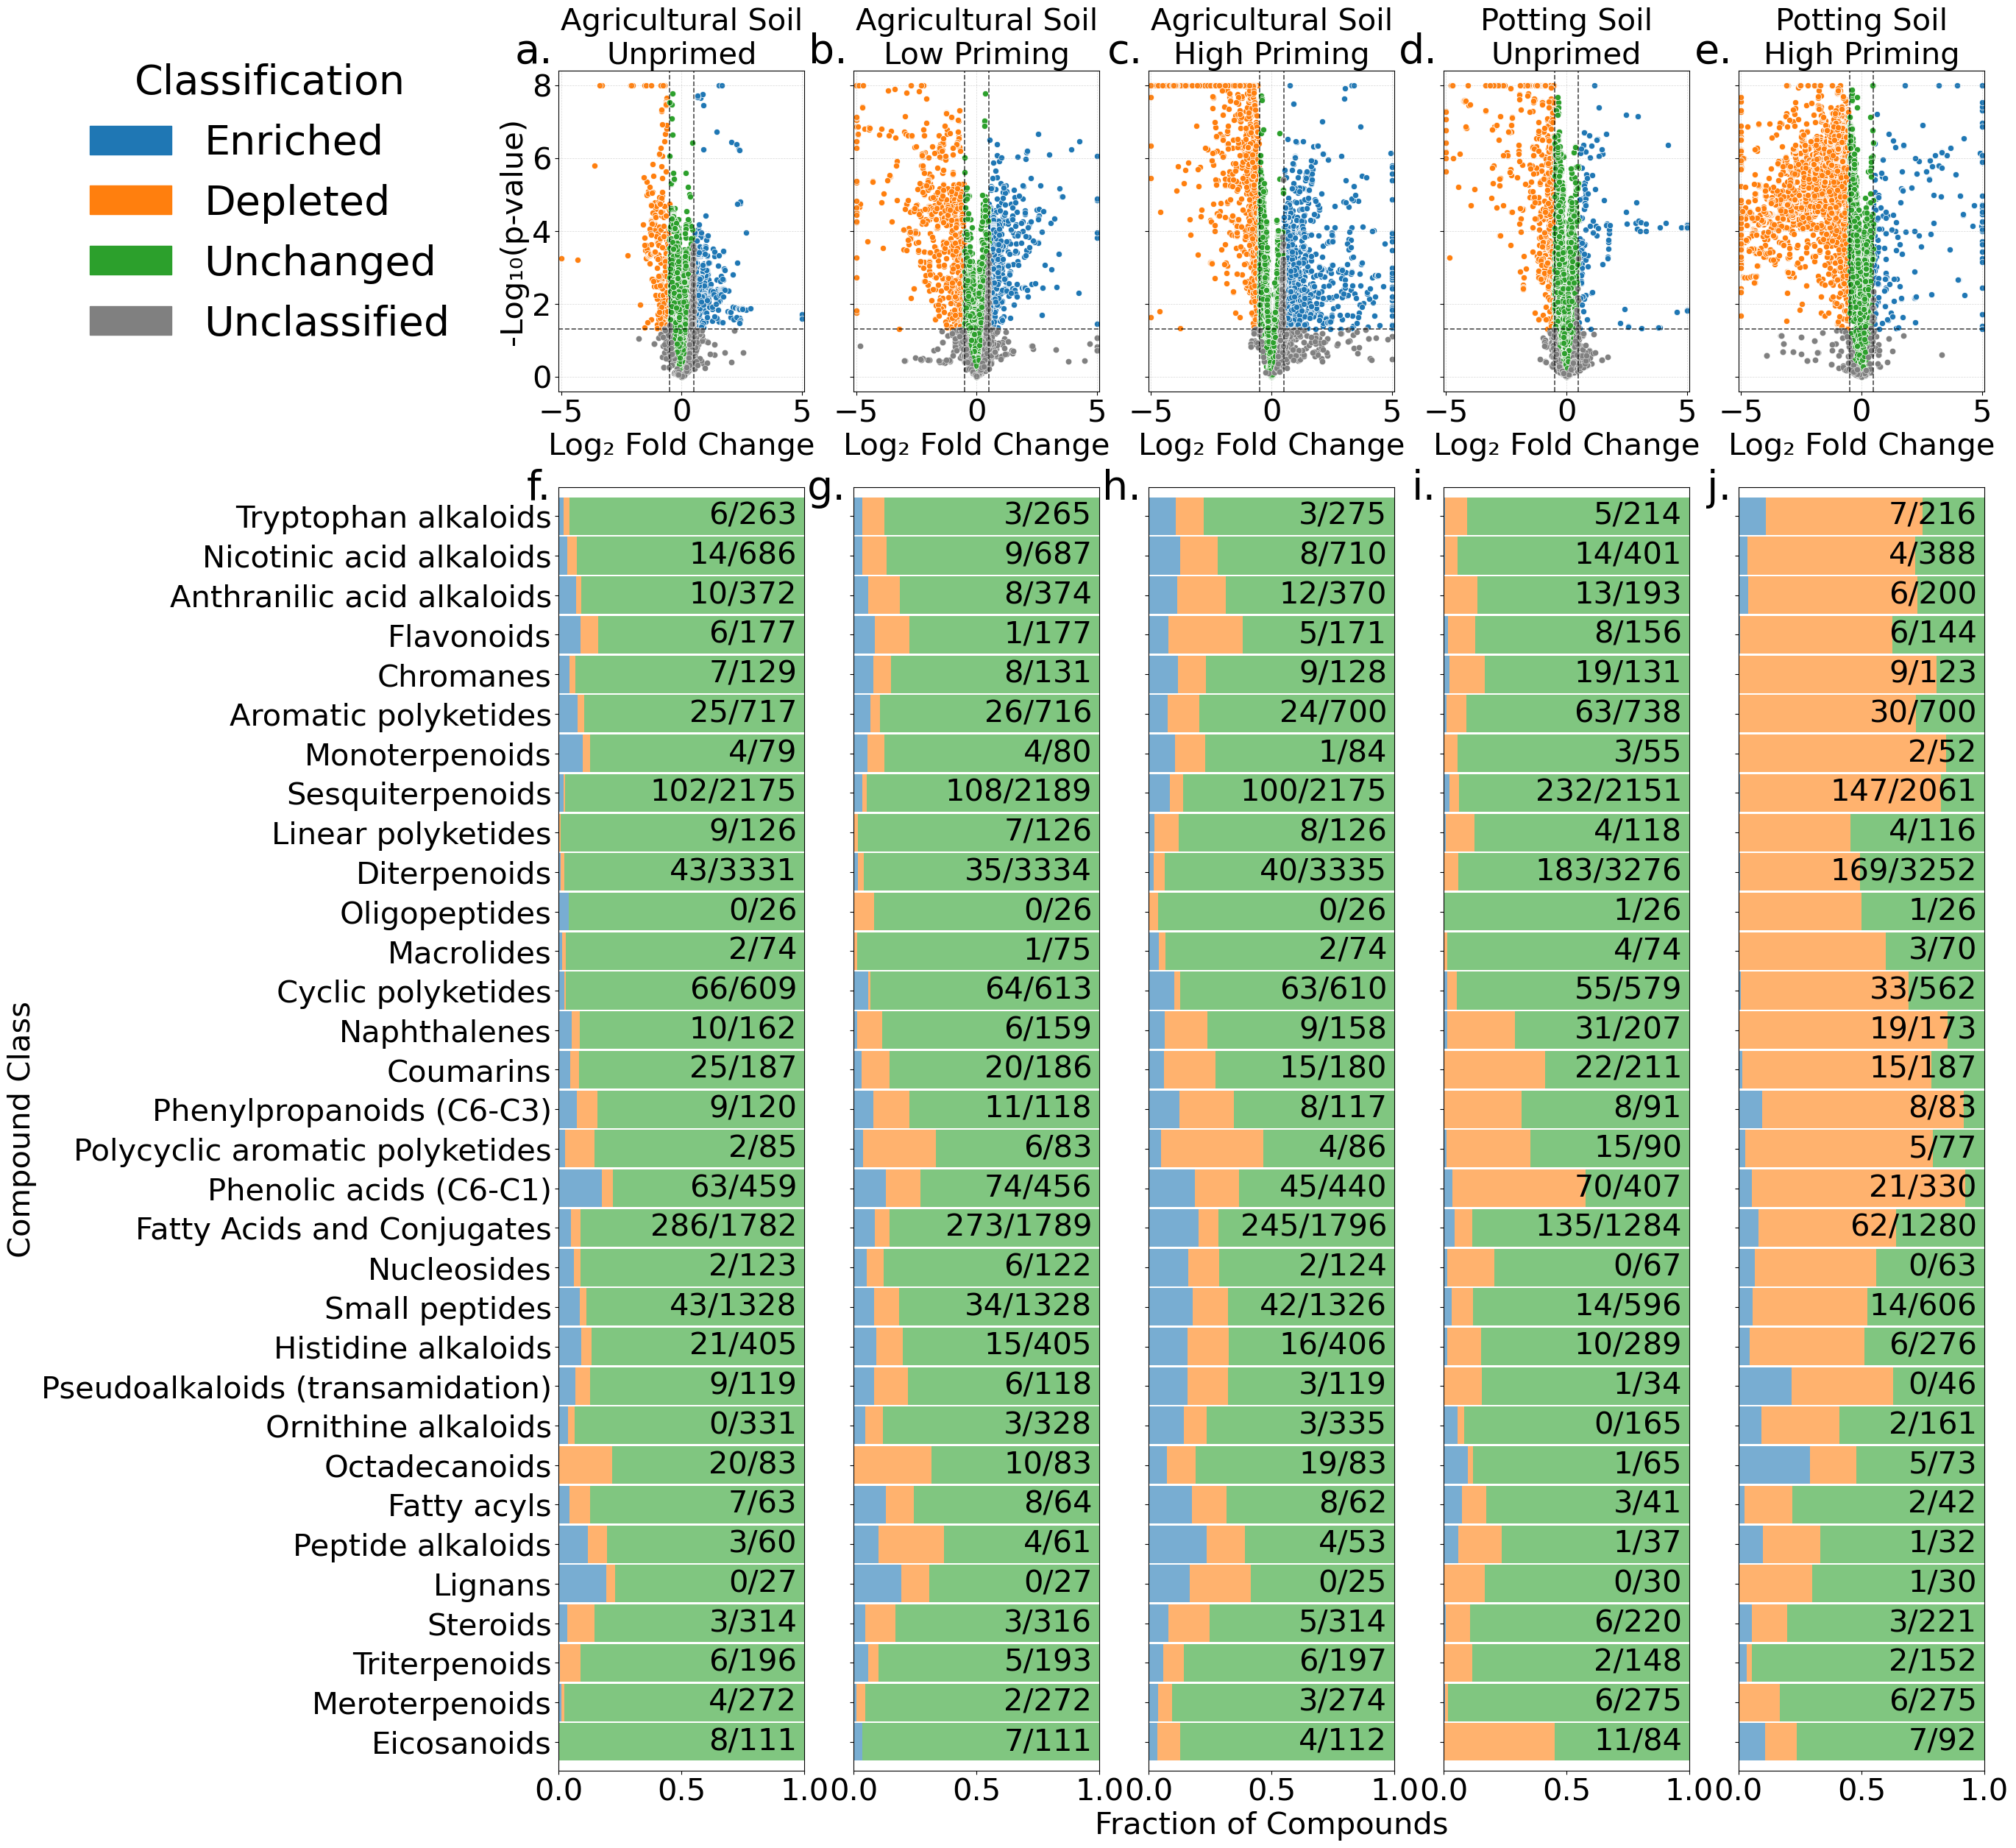

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Assume final_df and node_data are pre-loaded DataFrames
UNCLASSIFIED_COLOR = 'gray'
# --- Configuration Section ---
CLASSIFICATION_COLORS = {
    'enriched': '#1f77b4',
    'depleted': '#ff7f0e',
    'unchanged': '#2ca02c',
    'unclassified': UNCLASSIFIED_COLOR
}


MIN_COMPOUNDS_FOR_DISPLAY = 20

CONDITIONS = [
    {'soil_type': 'Agricultural Soil', 'priming': 'Unprimed', 'title': 'Agricultural Soil\nUnprimed'},
    {'soil_type': 'Agricultural Soil', 'priming': 'Low',      'title': 'Agricultural Soil\nLow Priming'},
    {'soil_type': 'Agricultural Soil', 'priming': 'High',     'title': 'Agricultural Soil\nHigh Priming'},
    {'soil_type': 'Potting Soil',      'priming': 'Unprimed',       'title': 'Potting Soil\nUnprimed'},
    {'soil_type': 'Potting Soil',      'priming': 'High',       'title': 'Potting Soil\nHigh Priming'}
]

compound_class_col = 'NPC#superclass'

# --- Helper Functions ---

def add_ms2_count_labels_v2(ax, ms2_counts, ms1_counts, soil_type, priming, bar_data, x_offset=0.02, fontsize=12):
    """
    Add MS2 count labels using the bar_data index directly.
    """
    for i, compound_class in enumerate(bar_data.index):
        try:
            count = ms2_counts.loc[compound_class, (soil_type, priming)]
            count_ms1 = ms1_counts.loc[compound_class, (soil_type, priming)]
            ax.text(0.95 + x_offset, i, f'{int(count)}/{int(count_ms1)}', 
                   va='center', ha='right', fontsize=fontsize,
                   transform=ax.get_yaxis_transform())
        except (KeyError, IndexError):
            pass


# --- Main Plotting Script ---
# filtered_final_df = final_df[final_df['has_ms2_evidence'] == True].copy()
filtered_final_df = final_df.copy()
global_class_order = get_combined_class_order(filtered_final_df, node_data, min_compounds=MIN_COMPOUNDS_FOR_DISPLAY)
print(f"Displaying {len(global_class_order)} most abundant compound classes.")

# Reduce spacing between subplots
fig = plt.figure(figsize=(25, 30))
# fig = plt.figure(figsize=(25, 34))
gs = gridspec.GridSpec(2, 5, height_ratios=[1, 4], hspace=0.12, wspace=0.2)
# gs = gridspec.GridSpec(2, 5, height_ratios=[1, 5], hspace=0.12, wspace=0.15)

axes_bar = []
axes_volcano = []  # Track volcano plot axes for sharing y-axis

for i, cond in enumerate(CONDITIONS):
    # Create volcano plot with shared y-axis
    ax_volcano = fig.add_subplot(gs[0, i], sharey=axes_volcano[0] if i > 0 else None)
    axes_volcano.append(ax_volcano)
    
    # Create bar chart with shared y-axis
    ax_bar = fig.add_subplot(gs[1, i], sharey=axes_bar[0] if i > 0 else None)
    axes_bar.append(ax_bar)

    idx = (filtered_final_df['soil_type'] == cond['soil_type'])
    if cond['priming'] is not None:
        idx &= (filtered_final_df['priming'] == cond['priming'])
    plot_df = filtered_final_df[idx].copy()
    plot_df = pd.merge(plot_df, node_data, on='original_index', how='left')
    
    create_volcano_plot(plot_df, ax_volcano, cond['title'])
    
    # Hide y-axis labels for volcano plots after the first one
    if i > 0:
        ax_volcano.set_ylabel('')
        plt.setp(ax_volcano.get_yticklabels(), visible=False)
    
    bar_data = prepare_barchart_data(plot_df, global_class_order)
    if not bar_data.empty:
        bar_data.plot(kind='barh', stacked=True, ax=ax_bar, width=0.95, alpha=0.6,
                      color=[CLASSIFICATION_COLORS[c] for c in bar_data.columns], legend=False)
        ax_bar.set_yticklabels(truncate_class_names(bar_data.index))
        add_ms2_count_labels_v2(ax_bar, ms2_counts, ms1_counts, cond['soil_type'], cond['priming'], 
                        bar_data, x_offset=0.02, fontsize=30)
    else:
        ax_bar.text(0.5, 0.5, 'No data', ha='center', va='center', fontsize=12, transform=ax_bar.transAxes)

    ax_bar.set_title('')
    if i==2:
        ax_bar.set_xlabel('Fraction of Compounds', fontsize=30)
    else:
        ax_bar.set_xlabel('')
    ax_bar.tick_params(axis='x', labelsize=30)
    ax_bar.tick_params(axis='y', labelsize=30)
    ax_bar.set_xlim(0,1)
    if i == 0:
        ax_bar.set_ylabel('Compound Class', fontsize=30)
    else:
        ax_bar.set_ylabel('')
        plt.setp(ax_bar.get_yticklabels(), visible=False)

legend_elements = [
    plt.Rectangle((0,0), 1, 1, color=CLASSIFICATION_COLORS['enriched'], label='Enriched'),
    plt.Rectangle((0,0), 1, 1, color=CLASSIFICATION_COLORS['depleted'], label='Depleted'),
    plt.Rectangle((0,0), 1, 1, color=CLASSIFICATION_COLORS['unchanged'], label='Unchanged'),
    plt.Rectangle((0,0), 1, 1, color=CLASSIFICATION_COLORS['unclassified'], label='Unclassified'),
]
fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(-0.15, 0.9),
           ncol=1, title='Classification', fontsize=40, title_fontsize=40, frameon=False)

# add panel labels lowercase letters with period
panel_labels = ['a.', 'b.', 'c.', 'd.', 'e.','f.', 'g.', 'h.', 'i.', 'j.']
counter = 0
for ax in axes_volcano:
    ax.text(-0.025, 1.12, panel_labels[counter], transform=ax.transAxes,
            fontsize=40, va='top', ha='right')
    counter += 1
for i, ax in enumerate(axes_bar):
    # if i>0:
    ax.text(-0.03, 1.015, panel_labels[counter], transform=ax.transAxes,
                fontsize=40, va='top', ha='right')
    # else:
    # ax.text(-0.8, 1.03, panel_labels[counter], transform=ax.transAxes,
                # fontsize=40, va='top', ha='right')
    counter += 1
# Adjust layout with reduced margins
# plt.tight_layout(rect=[0, 0.04, 1, 0.97])
plt.show()

In [24]:
filtered_final_df = final_df.copy()
global_class_order = get_combined_class_order(filtered_final_df, node_data, min_compounds=MIN_COMPOUNDS_FOR_DISPLAY)
filtered_final_df = pd.merge(filtered_final_df, node_data, on='original_index', how='left')
filtered_final_df = filtered_final_df[filtered_final_df[compound_class_col].isin(global_class_order)]
ms1_counts = filtered_final_df.groupby(['soil_type','priming',compound_class_col])['has_ms2_evidence'].count()
ms1_counts = ms1_counts.unstack(fill_value=0).T
ms1_counts = ms1_counts.reindex(global_class_order).dropna()
ms1_counts

soil_type                  20M permafrost 42M permafrost 55M permafrost  \
priming                          Unprimed       Unprimed       Unprimed   
NPC#superclass                                                            
Fatty acyls                            19             27             33   
Triterpenoids                          54            137            159   
Steroids                               51            146            243   
Eicosanoids                            41             94             99   
Octadecanoids                          67             81             80   
Phenolic acids (C6-C1)                 52            141            235   
Coumarins                              37             97            132   
Linear polyketides                     31             84            123   
Diterpenoids                          151           2088           3246   
Cyclic polyketides                    103            476            584   
Anthranilic acid alkaloids             19            121            211   
Aromatic polyketides                   52            230            505   
Tryptophan alkaloids                   18            110            194   
Sesquiterpenoids                      222           1509           2170   
Fatty Acids and Conjugates            684           1377           1551   
Histidine alkaloids                    34            141            291   
Small peptides                         83            502            797   

soil_type                  66M permafrost 82M permafrost Agricultural Soil  \
priming                          Unprimed       Unprimed              High   
NPC#superclass                                                               
Fatty acyls                            27             26                62   
Triterpenoids                         146            149               197   
Steroids                              166            178               314   
Eicosanoids                            95             95               112   
Octadecanoids                          79             79                83   
Phenolic acids (C6-C1)                178            184               440   
Coumarins                              99            103               180   
Linear polyketides                    106            105               126   
Diterpenoids                         2944           2954              3335   
Cyclic polyketides                    554            557               610   
Anthranilic acid alkaloids            152            163               370   
Aromatic polyketides                  357            357               700   
Tryptophan alkaloids                  159            163               275   
Sesquiterpenoids                     1938           1955              2175   
Fatty Acids and Conjugates           1461           1448              1796   
Histidine alkaloids                   189            199               406   
Small peptides                        615            604              1326   

soil_type                                 Potting Soil           
priming                      Low Unprimed         High Unprimed  
NPC#superclass                                                   
Fatty acyls                   64       63           42       41  
Triterpenoids                193      196          152      148  
Steroids                     316      314          221      220  
Eicosanoids                  111      111           92       84  
Octadecanoids                 83       83           73       65  
Phenolic acids (C6-C1)       456      459          330      407  
Coumarins                    186      187          187      211  
Linear polyketides           126      126          116      118  
Diterpenoids                3334     3331         3252     3276  
Cyclic polyketides           613      609          562      579  
Anthranilic acid alkaloids   374      372          200      193  
Aromatic polyk

In [25]:
filtered_final_df = final_df.copy()
global_class_order = get_combined_class_order(filtered_final_df, node_data, min_compounds=MIN_COMPOUNDS_FOR_DISPLAY)
filtered_final_df = filtered_final_df[filtered_final_df['has_ms2_evidence'] == True]
filtered_final_df = pd.merge(filtered_final_df, node_data, on='original_index', how='left')
filtered_final_df = filtered_final_df[filtered_final_df[compound_class_col].isin(global_class_order)]
filtered_final_df.columns
ms2_counts = filtered_final_df.groupby(['soil_type','priming',compound_class_col])['has_ms2_evidence'].value_counts()
ms2_counts = ms2_counts.unstack(fill_value=0).reset_index()
ms2_counts.rename(columns={True:'ms2_count'}, inplace=True)
ms2_counts = pd.pivot_table(ms2_counts, values='ms2_count', index=[compound_class_col], columns=['soil_type','priming'], fill_value=0)
# put in order of global_class_order
ms2_counts = ms2_counts.reindex(global_class_order).dropna()
ms2_counts

soil_type                  20M permafrost 42M permafrost 55M permafrost  \
priming                          Unprimed       Unprimed       Unprimed   
NPC#superclass                                                            
Fatty acyls                             0              1              1   
Triterpenoids                           2              6              1   
Steroids                                0              9              0   
Eicosanoids                             1              6              1   
Octadecanoids                           4             15              4   
Phenolic acids (C6-C1)                  4              9              1   
Coumarins                               3             17              0   
Linear polyketides                      0              7              1   
Diterpenoids                            0             16             18   
Cyclic polyketides                      0             19             11   
Anthranilic acid alkaloids              1              1              0   
Aromatic polyketides                    2              4              3   
Tryptophan alkaloids                    0              1              1   
Sesquiterpenoids                        2             40             63   
Fatty Acids and Conjugates             42            219            103   
Histidine alkaloids                     4              5              2   
Small peptides                          0              9              5   

soil_type                  66M permafrost 82M permafrost Agricultural Soil  \
priming                          Unprimed       Unprimed              High   
NPC#superclass                                                               
Fatty acyls                             1              1                 8   
Triterpenoids                           6              3                 6   
Steroids                                7             10                 5   
Eicosanoids                             8             12                 4   
Octadecanoids                          10              9                19   
Phenolic acids (C6-C1)                 13             13                45   
Coumarins                              10             12                15   
Linear polyketides                      4              3                 8   
Diterpenoids                           64            118                40   
Cyclic polyketides                     35             51                63   
Anthranilic acid alkaloids              9             10                12   
Aromatic polyketides                   11             11                24   
Tryptophan alkaloids                    2              3                 3   
Sesquiterpenoids                      174            251               100   
Fatty Acids and Conjugates            205            215               245   
Histidine alkaloids                     8              8                16   
Small peptides                         10             17                42   

soil_type                                Potting Soil           
priming                     Low Unprimed         High Unprimed  
NPC#superclass                                                  
Fatty acyls                   8        7            2        3  
Triterpenoids                 5        6            2        2  
Steroids                      3        3            3        6  
Eicosanoids                   7        8            7       11  
Octadecanoids                10       20            5        1  
Phenolic acids (C6-C1)       74       63           21       70  
Coumarins                    20       25           15       22  
Linear polyketides            7        9            4        4  
Diterpenoids                 35       43          169      183  
Cyclic polyketides           64       66           33       55  
Anthranilic acid alkaloids    8       10            6       13  
Aromatic polyketides        

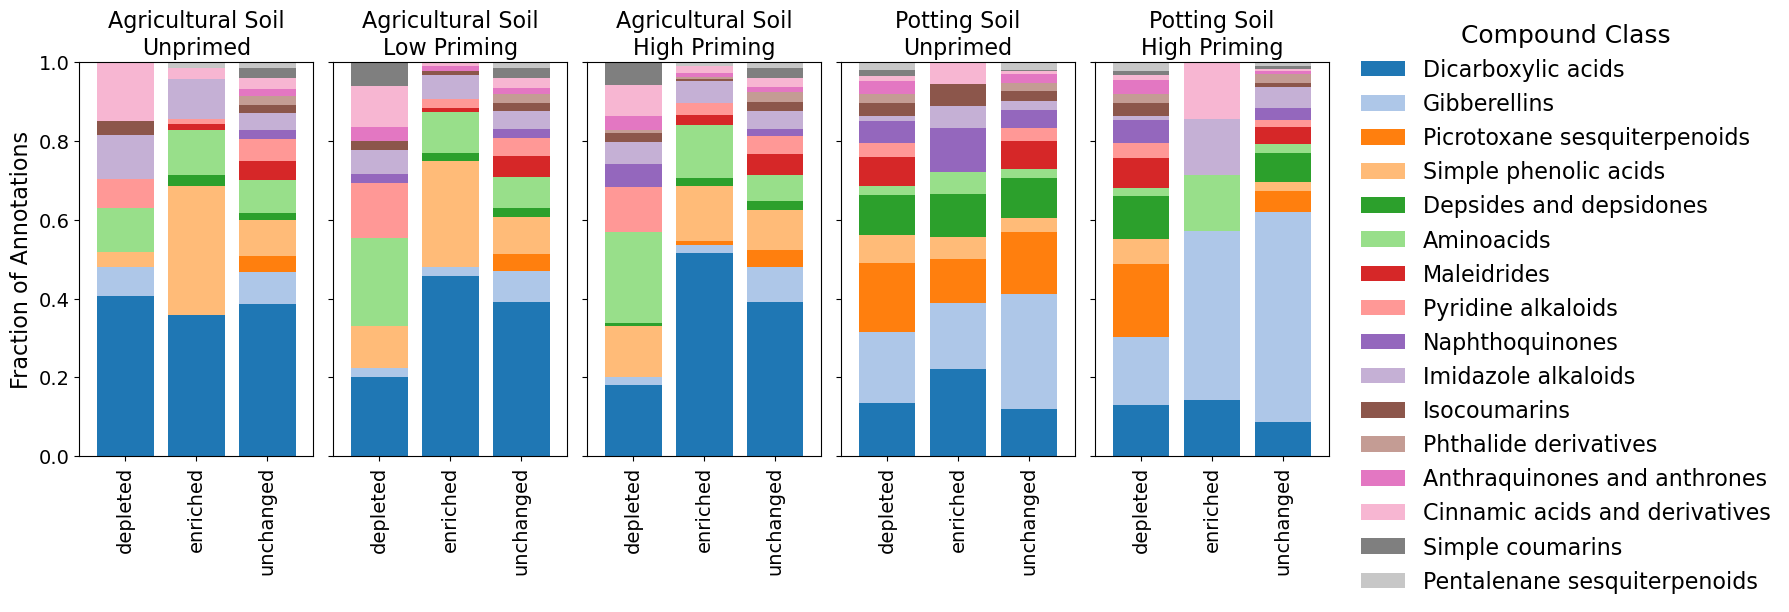

In [85]:
# Use the same CONDITIONS as the previous figure
# CONDITIONS = [
#     {'soil_type': 'Agricultural Soil', 'priming': 'Unprimed', 'title': 'Agricultural Soil\nUnprimed'},
#     {'soil_type': 'Agricultural Soil', 'priming': 'Low',      'title': 'Agricultural Soil\nLow Priming'},
#     {'soil_type': 'Agricultural Soil', 'priming': 'High',     'title': 'Agricultural Soil\nHigh Priming'},
#     {'soil_type': 'Potting Soil',      'priming': None,       'title': 'Potting Soil'}
# ]

plot_df = final_df[final_df['has_ms2_evidence'] == True].copy()
fig, all_axes = plt.subplots(figsize=(18, 6), nrows=1, ncols=len(CONDITIONS), sharey=True)

class_term = 'NPC#class'

# First pass: collect all compound classes across all conditions to determine global order
all_class_counts = {}
for cond in CONDITIONS:
    idx1 = plot_df['classification'].notna()
    idx2 = plot_df['soil_type'] == cond['soil_type']
    if cond['priming'] is not None:
        idx2 &= (plot_df['priming'] == cond['priming'])
    idx = idx1 & idx2
    
    classified_indices = plot_df[idx].groupby('classification')['original_index'].unique().to_dict()
    
    for key, value in classified_indices.items():
        idx_node = node_data['original_index'].isin(value)
        temp = node_data.loc[idx_node, class_term].value_counts()
        for class_name, count in temp.items():
            all_class_counts[class_name] = all_class_counts.get(class_name, 0) + count

# Filter classes that appear frequently enough and sort by total abundance
class_threshold = 0.05  # Adjust this threshold as needed
total_count = sum(all_class_counts.values())
global_class_order = [cls for cls, count in all_class_counts.items() 
                      if count / total_count > class_threshold / len(CONDITIONS)]
global_class_order = sorted(global_class_order, key=lambda x: all_class_counts[x], reverse=True)

# Second pass: create plots with consistent ordering
for counter, cond in enumerate(CONDITIONS):
    ax = all_axes[counter]
    
    idx1 = plot_df['classification'].notna()
    idx2 = plot_df['soil_type'] == cond['soil_type']
    if cond['priming'] is not None:
        idx2 &= (plot_df['priming'] == cond['priming'])
    idx = idx1 & idx2
    
    classified_indices = plot_df[idx].groupby('classification')['original_index'].unique().to_dict()
    out = []
    
    for key, value in classified_indices.items():
        idx_node = node_data['original_index'].isin(value)
        temp = node_data.loc[idx_node, class_term].value_counts()
        temp = temp.to_frame().reset_index().rename(columns={'index': 'class', class_term: 'count'})
        temp['classification'] = key
        temp['total'] = temp['count'].sum()
        temp['fraction'] = temp['count'] / temp['total']
        out.append(temp)
    
    class_df = pd.concat(out, ignore_index=True)
    class_df = class_df.pivot(index='classification', columns='class', values='fraction')
    class_df.fillna(0, inplace=True)
    
    # Reindex to use global class order
    class_df = class_df.reindex(columns=global_class_order, fill_value=0)
    
    # Sum each row to one
    class_df = class_df.div(class_df.sum(axis=1), axis=0)
    
    class_df.plot(kind='bar', stacked=True, ax=ax, width=0.8,
                  color=sns.color_palette("tab20", n_colors=len(global_class_order)))
    ax.set_ylabel('Fraction of Annotations', fontsize=16)
    ax.set_xlabel('', fontsize=14)
    ax.set_title(cond['title'], fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_ylim(0, 1)
    # Only show legend on the last subplot
    if counter == len(CONDITIONS) - 1:
        ax.legend(bbox_to_anchor=(1.05, 1.15), loc='upper left', fontsize=16, title='Compound Class', title_fontsize=18,frameon=False )
    else:
        ax.get_legend().remove()

plt.tight_layout()
plt.show()

In [47]:
# ms2_filename = '/pscratch/sd/b/bpb/envnet_annotation_results/ms2_results_experiments_for_paper/ms2_deconvoluted_annotations.parquet'
# ms2_cols = ['score_deconvoluted_match', 'matches_deconvoluted_match',
#        'original_index_deconvoluted_match',  'filename',
#         'mz_diff']
# ms2_df = pd.read_parquet(ms2_filename, columns=ms2_cols)

# fig,ax = plt.subplots(1,2,figsize=(10,6),sharex=True,sharey=True)

# my_file = '/global/cfs/cdirs/metatlas/projects/envnet_build_files/analysis_for_manuscript/20240125_EB_MdR_101544-059_WAVESTAB3_20231222_EXP120A_C18-EP_USDAY72349_NEG_MS2_23_supern-CentExp-OMT1d2-NatCom-d7-NA_3_6uL_054.h5'
# idx = ms2_df['filename'].str.contains('WAVEstab')
# plot_df = ms2_df[idx].copy()
# plot_df.sort_values(by='score_deconvoluted_match', ascending=False, inplace=True)
# plot_df.drop_duplicates(subset=['original_index_deconvoluted_match'], keep='first', inplace=True)
# plot_df = pd.merge(plot_df,node_data, left_on='original_index_deconvoluted_match', right_on='original_index', how='left')
# p = pd.pivot_table(plot_df,index='predicted_formula', values='score_deconvoluted_match',columns='NPC#class')
# p = p.notna()
# num_ms2 = p.sum(axis=1)
# p = pd.pivot_table(node_data,index='predicted_formula', values='original_index',columns='NPC#class')
# p = p.notna()
# num_ms1 = p.sum(axis=1)
# d = num_ms1.value_counts()
# ax[0].bar(d.index, d.values)
# ax[0].set_yscale('log')
# d = num_ms2.value_counts()
# ax[1].bar(d.index, d.values)
# ax[1].set_yscale('log')

In [ ]:
# sum(temp['NPC#class_no_ms2']==1)/# temp = final_df[final_df['classification'].notna()]
# idx1 = temp['soil_type'] == 'Agricultural Soil'
# idx2 = temp['classification'] == 'prefered'
# idx3 = temp['classification'] == 'produced'
# temp = temp[idx1].copy()# & (idx2 | idx3)].copy()
# temp = pd.merge(temp, node_data, on='original_index', how='left')
# temp = temp.groupby('predicted_formula')['classification'].value_counts().unstack(fill_value=0)
# print("There are {} formulas that are prefered, produced or ignored".format(len(temp)))
# idx1 = (temp>0).sum(axis=1)>1
# print('There are {} formulas that are prefered and produced or ignored'.format(temp[idx1].shape[0]))
# temp = temp[(temp['prefered']>1) & (temp['produced']>1)].copy()
# temp
# prediction_df = pd.merge(final_df[final_df['soil_type'].str.contains('soil',case=False)], node_data, on='original_index', how='right')
# idx = (pd.notna(prediction_df['NPC#class'])) & (prediction_df['predicted_unchanged_in_soil'].notna())
# classified_compounds = prediction_df[idx].copy()
# # for each NPC#class get 0,1 from predicted_unchanged_in_soil
# summary = classified_compounds.groupby('NPC#class').apply(
#     lambda x: pd.Series({
#         'num_compounds': x.shape[0],
#         'num_predicted_unchanged': x['predicted_unchanged_in_soil'].sum(),
#         # 'num_predicted_changed': sum(pd.notna(x['predicted_unchanged_in_soil'])) - x['predicted_unchanged_in_soil'].sum(),
#         'fraction_predicted_unchanged': x['predicted_unchanged_in_soil'].mean(),
#         # 'total_classified': sum(pd.notna(x['predicted_unchanged_in_soil']))
#     })
# ).reset_index()
# summary = summary[summary['num_compounds']>=20].copy()
# summary = summary.sort_values('fraction_predicted_unchanged', ascending=False)

# fig,ax = plt.subplots(1,1,figsize=(6,4))
# summary['fraction_predicted_unchanged'].hist(bins=20, ax=ax)
# ax.set_xlabel('Fraction of compounds predicted unchanged in soil')
# ax.set_ylabel('Number of compound classes')
# plt.tight_layout()
# prediction_df = pd.merge(final_df[final_df['soil_type'].str.contains('soil',case=False)], node_data, on='original_index', how='right')
# idx = d.notna(prediction_df['smiles'])
# classified_compounds = prediction_df[idx].copy()
# classified_compounds = classified_compounds.loc[classified_compounds['t'].isna(),['smiles','predicted_unchanged_in_soil']]
# classified_compounds.drop_duplicates(inplace=True)

# # use rdkit to draw compounds and label them by predicted_unchanged_in_soil
# from rdkit import Chem
# from rdkit.Chem import Draw
# from rdkit.Chem.Draw import rdMolDraw2D
# mols = []
# legends = []
# for _, row in classified_compounds.iterrows():
#     mol = Chem.MolFromSmiles(row['smiles'])
#     if mol is not None:
#         mol.SetProp('predicted_unchanged_in_soil', str(row['predicted_unchanged_in_soil']))
#         mols.append(mol)
#         legends.append(f"Predicted unchanged in soil: {row['predicted_unchanged_in_soil']}")
# # sort them by their legends
# mols, legends = zip(*sorted(zip(mols, legends), key=lambda x: x[1], reverse=True))

# img = Draw.MolsToGridImage(mols, molsPerRow=4, useSVG=True, subImgSize=(200,200), legends=legends)
# # with open('classified_compounds.svg', 'w') as f:
#     # f.write(img.data)

# # these are the not observed compounds in soil that have a prediction probability
# from scipy.stats import ttest_1samp, wilcoxon
# prediction_df = pd.merge(final_df[final_df['soil_type'].str.contains('soil',case=False)], node_data, on='original_index', how='right')
# prediction_df = prediction_df[pd.isna(prediction_df['fc'])].copy()

# # observed_df = pd.merge(final_df[final_df['soil_type'].str.contains('soil',case=False)], node_data, on='original_index', how='left')
# # observed_df['measured_unchanged_in_soil'] = None
# # idx = observed_df['classification']=='ignored'
# # observed_df.loc[idx,'measured_unchanged_in_soil'] = 1.0
# # idx = (observed_df['classification']=='prefered') | (observed_df['classification']=='produced')
# # observed_df.loc[idx,'measured_unchanged_in_soil'] = 0.0
# # observed_df = observed_df[pd.notna(observed_df['measured_unchanged_in_soil'])].copy()
# observed_df = pd.merge(final_df[final_df['soil_type'].str.contains('soil',case=False)], node_data, on='original_index', how='left')
# g = observed_df.groupby(['original_index'])['classification'].apply(my_class_fun)
# g = g.to_frame()
# g.columns = ['measured_unchanged_in_soil']
# g.index.name = 'original_index'
# g.reset_index()
# observed_df = pd.merge(g,node_data,on='original_index',how='left')

# def calculate_significance_stats(group):
#     """Calculate various statistical tests for probability significance"""
#     probs = group.dropna()
#     if len(probs) < 3:  # Need minimum samples for statistical tests
#         return pd.Series({
#             'count': len(probs),
#             'mean': np.nan,
#             'median': np.nan,
#             'ttest_pvalue': np.nan,
#             'wilcoxon_pvalue': np.nan,
#             'prop_high': np.nan,
#             'prop_low': np.nan
#         })
    
#     # Basic statistics
#     mean_prob = probs.mean()
#     median_prob = probs.median()
#     count = len(probs)
    
#     # One-sample t-test: tests if mean is significantly different from 0.5
#     t_stat, t_pvalue = ttest_1samp(probs, 0.5)
    
#     # Wilcoxon signed-rank test: non-parametric test if median differs from 0.5
#     try:
#         # Subtract 0.5 to center around 0 for the test
#         w_stat, w_pvalue = wilcoxon(probs - 0.5)
#     except ValueError:
#         # Happens when all values are exactly 0.5
#         w_pvalue = 1.0
    
#     # Proportion-based measures
#     prop_high = (probs > 0.7).sum() / count  # Proportion with high confidence
#     prop_low = (probs < 0.3).sum() / count   # Proportion with low confidence
    
#     return pd.Series({
#         'count': count,
#         'mean': mean_prob,
#         'median': median_prob,
#         'ttest_pvalue': t_pvalue,
#         'wilcoxon_pvalue': w_pvalue,
#         'prop_high': prop_high,
#         'prop_low': prop_low
#     })

# # Apply the function and properly handle the result
# g = prediction_df.groupby('NPC#class')['predicted_unchanged_in_soil'].apply(calculate_significance_stats)
# # Unstack to convert the multi-index Series to a DataFrame
# g = g.unstack().reset_index()
# g = g[g['count']>=20].copy().sort_values('mean', ascending=False)

# # Add significance flags
# g['ttest_significant'] = g['ttest_pvalue'] < 0.05
# g['wilcoxon_significant'] = g['wilcoxon_pvalue'] < 0.05
# g['strongly_biased'] = (g['prop_high'] > 0.8) | (g['prop_low'] > 0.8)

# print("Compound classes with significant deviations from 0.5 (t-test):")
# print(g[g['ttest_significant']]['NPC#class'].tolist())
# print(f"\n{g['ttest_significant'].sum()} out of {len(g)} classes show significant bias")

# # get the ones where one of the three ttests are significant
# significant_classes = g[g['ttest_significant'] & g['wilcoxon_significant']]

# # get the top and bottom 5 classes by mean predicted_unchanged_in_soil
# top_5 = significant_classes[significant_classes['mean'] > 0.5].head(5)
# bottom_5 = significant_classes[significant_classes['mean'] < 0.5].tail(5)

# selected_classes = pd.concat([top_5, bottom_5])
# print("Selected compound classes for further analysis:")
# # there are 6 final classes
# # go back to prediction_df and get all compounds in these classes and pie chart their predicted_unchanged_in_soil
# for cls in selected_classes['NPC#class']:
#     class_compounds = prediction_df[prediction_df['NPC#class'] == cls]
#     counts = class_compounds['predicted_unchanged_in_soil'].value_counts(normalize=True)
#     print(f"\nClass: {cls}")
#     print(counts)

# # Define consistent colors: 0 (changed) = blue, 1 (unchanged) = orange
# pie_colors = {0.0: 'blue', 1.0: 'orange'}
# pie_colors_data = {0.0: 'green', 1.0: 'purple'}
# fig, ax = plt.subplots(2, 6, figsize=(14, 8))
# ax = ax.flatten()

# counter = 0
# for cls in selected_classes['NPC#class']:
#     if counter >= 6:  # Only show first 6 classes
#         break
    
#     class_compounds = prediction_df[prediction_df['NPC#class'] == cls]
#     counts = class_compounds['predicted_unchanged_in_soil'].value_counts(normalize=True)
    
#     # Ensure we have consistent ordering and colors
#     sizes = []
#     colors = []
    
#     for value in [0.0, 1.0]:  # Ensure consistent order
#         if value in counts.index:
#             sizes.append(counts[value])
#             colors.append(pie_colors[value])
    
#     # Only create pie chart if we have data
#     if sizes:
#         # Create pie chart without labels
#         ax[counter].pie(sizes, colors=colors, autopct='%d%%', startangle=90)
#         # switch count first or second if even or odd
#         if counter % 2 == 0:
#             ax[counter].set_title(f"{cls}\n(n={len(class_compounds)})")
#         else:
#             ax[counter].set_title(f"(n={len(class_compounds)})\n{cls}")
#     else:
#         ax[counter].text(0.5, 0.5, f"{cls}\nNo data", ha='center', va='center', transform=ax[counter].transAxes)
#         ax[counter].set_xlim(0, 1)
#         ax[counter].set_ylim(0, 1)
    
#     counter += 1

# # now do it for observed compounds in soil
# for cls in selected_classes['NPC#class']:

#     class_compounds = observed_df[observed_df['NPC#class'] == cls]
#     counts = class_compounds['measured_unchanged_in_soil'].value_counts(normalize=True)
    
#     # Ensure we have consistent ordering and colors
#     sizes = []
#     colors = []
    
#     for value in [0.0, 1.0]:  # Ensure consistent order
#         if value in counts.index:
#             sizes.append(counts[value])
#             colors.append(pie_colors_data[value])


#     # Only create pie chart if we have data
#     if sizes:
#         # Create pie chart without labels
#         ax[counter].pie(sizes, colors=colors, autopct='%d%%', startangle=90)
#         # switch count first or second if even or odd
#         if counter % 2 == 0:
#             ax[counter].set_title(f"{cls}\n(n={len(class_compounds)})")
#         else:
#             ax[counter].set_title(f"(n={len(class_compounds)})\n{cls}")
#     else:
#         ax[counter].text(0.5, 0.5, f"{cls}\nNo data", ha='center', va='center', transform=ax[counter].transAxes)
#         ax[counter].set_xlim(0, 1)
#         ax[counter].set_ylim(0, 1)
    
#     counter += 1

# # Hide any unused subplots
# for i in range(counter, 6):
#     ax[i].axis('off')

# # Create a single legend for the entire figure
# legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
#                              markersize=10, label='Changed'),
#                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', 
#                              markersize=10, label='Unchanged'),
#                 plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green',
#                              markersize=10, label='Measured Changed'),
#                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='purple',
#                              markersize=10, label='Measured Unchanged')]

# fig.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.2, 0.65), 
#            title='Prediction', frameon=True)

# plt.tight_layout()
# plt.show()
# prediction_df = pd.merge(final_df[final_df['soil_type'].str.contains('soil',case=False)], node_data, on='original_index', how='left')

# fig,ax = plt.subplots(1,1,figsize=(6,5))
# # make a 2d histogram of prediction_df['predicted_unchanged_in_soil_prob'] vs prediction_df['fc']
# hb = ax.hexbin(prediction_df['predicted_unchanged_in_soil_prob'], prediction_df['fc'],
#                gridsize=20, cmap='plasma', mincnt=1, bins='log', 
#                reduce_C_function=np.sqrt)
# # fill the empty bins with black
# ax.set_facecolor('black')
# ax.set_xlabel('Prediction Probability (unchanged in soil)')
# ax.set_ylabel('Log2 Fold Change (Day7/Day0)')
# cb = fig.colorbar(hb, ax=ax)
# cb.set_label('Sqrt(Counts)')
# plt.tight_layout()
# prediction_df = pd.merge(final_df[final_df['soil_type'].str.contains('soil',case=False)], node_data, on='original_index', how='left')

# fig,ax = plt.subplots(1,1,figsize=(6,3))
# idx = (prediction_df['predicted_unchanged_in_soil']==1) & (pd.notna(prediction_df['classification']))
# edges = np.linspace(-5,5,50)
# sns.histplot(prediction_df[idx], x='fc', bins=edges, color='blue', label='predicted unchanged', ax=ax, stat='density', alpha=0.5)
# idx = (prediction_df['predicted_unchanged_in_soil']==0) & (pd.notna(prediction_df['classification']))
# sns.histplot(prediction_df[idx], x='fc', bins=edges, color='orange', label='predicted changed', ax=ax, stat='density', alpha=0.5)
# ax.set_xlabel('Log2 Fold Change (Day 7 / Day 0)')
# ax.set_ylabel('Density')
# # ax.set_yscale('log')
# blue_patch = mpatches.Patch(color='blue', label='Predicted Unchanged')
# orange_patch = mpatches.Patch(color='orange', label='Predicted Changed')
# ax.legend(handles=[blue_patch, orange_patch])
# plt.show()

# top_classes = prediction_df['NPC#class'].value_counts().head(10).index.tolist()
# temp = prediction_df[prediction_df['NPC#class'].isin(top_classes)].copy()
# fig,ax = plt.subplots(1,1,figsize=(8,4))
# # make a violin plot of fold change for each class colored by predicted_unchanged_in_soil
# # Remove inner box plots to reduce clutter
# sns.violinplot(data=temp, x='NPC#class', y='fc', hue='predicted_unchanged_in_soil', split=True, ax=ax, inner=None)
# ax.set_ylim(-2,2)
# ax.set_xlabel('NPC#class')
# ax.set_ylabel('Log2 Fold Change (Day 7 / Day 0)')
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
# # move legend outside of plot
# ax.legend(title='Predicted Unchanged in Soil', loc='upper left', bbox_to_anchor=(1, 1)) 
# plt.tight_layout()
# plt.show()


# true_positives = prediction_df[(prediction_df['classification']=='ignored') & (prediction_df['predicted_unchanged_in_soil']==1)]
# print("There are {} true positives".format(true_positives.shape[0]))
# true_negatives = prediction_df[(prediction_df['classification']!='ignored') & (prediction_df['predicted_unchanged_in_soil']==0)]
# print("There are {} true negatives".format(true_negatives.shape[0]))
# false_positives = prediction_df[(prediction_df['classification']!='ignored') & (prediction_df['predicted_unchanged_in_soil']==1)]
# print("There are {} false positives".format(false_positives.shape[0]))
# false_negatives = prediction_df[(prediction_df['classification']=='ignored') & (prediction_df['predicted_unchanged_in_soil']==0)]
# print("There are {} false negatives".format(false_negatives.shape[0]))
# y_true = prediction_df['classification'].apply(lambda x: 1 if x=='ignored' else 0).values
# y_pred = prediction_df['predicted_unchanged_in_soil'].values
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# cm = confusion_matrix(y_true, y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['changed','unchanged'])
# disp.plot(cmap=plt.cm.Blues)
# plt.title('Prediction of unchanged compounds in soil incubations')
# plt.show()

# # precision and recall
# tp = true_positives.shape[0]
# fp = false_positives.shape[0]
# fn = false_negatives.shape[0]
# precision = tp / (tp + fp) if (tp + fp) > 0 else 0
# recall = tp / (tp + fn) if (tp + fn) > 0 else 0
# f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
# print(f'Precision: {precision:.2f}')
# print(f'Recall: {recall:.2f}')
# print(f'F1 Score: {f1_score:.2f}')  

# # matthews correlation coefficient
# tn = true_negatives.shape[0]
# mcc_numerator = (tp * tn) - (fp * fn)
# mcc_denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
# mcc = mcc_numerator / mcc_denominator if mcc_denominator > 0 else 0
# print(f'Matthews Correlation Coefficient: {mcc:.2f}')
# import pandas as pd
# usecols = ['original_index', 't', 'p', 'fc', 'tost',
#        'mean_treatment', 'mean_control', 'treatment_vals', 'control_vals',
#        'project', 'priming', 'soil_type', 'classification',
#        'summary_classification', 'node_order_index', 'deconvoluted_spectrum',
#        'all_features_prediction', 'formula_based_prediction']
# prediction_df = pd.read_csv('training_data_with_predictions_full.csv', usecols=usecols)

# prediction_df = prediction_df[prediction_df['classification'].notna()]
# idx1 = prediction_df['soil_type'] == 'Agricultural Soil'


# prediction_df = pd.merge(prediction_df, node_data, on='original_index', how='left')

# g = prediction_df.groupby('predicted_formula')['classification'].value_counts().unstack(fill_value=0)
# print("There are {} formulas that are prefered, produced or ignored".format(len(g)))
# idx1 = (g>0).sum(axis=1)>1
# complex_ones = g[idx1].index.tolist()
# print('There are {} formulas that are prefered and produced or ignored'.format(g[idx1].shape[0]))
# # temp = temp[(temp['prefered']>1) & (temp['produced']>1)].copy()
# g = prediction_df.groupby('predicted_formula')[['classification','formula_based_prediction','all_features_prediction']].agg(lambda x: tuple(x)).reset_index()
# def replace_words_with_numbers(x):
#     out = []
#     for xx in x:
#         if xx=='prefered':
#             out.append(0)
#         elif xx=='produced':
#             out.append(0)
#         elif xx=='ignored':
#             out.append(1)
#     return tuple(out)
    
# g['classification'] = g['classification'].apply(replace_words_with_numbers)
# g = g[g['predicted_formula'].isin(complex_ones)].copy()
# # g = g[['predicted_formula','classification','formula_based_prediction','all_features_prediction']]
# # idx = g['formula_based_prediction'] != g['all_features_prediction']
# g['disagreement'] = g['classification'].apply(lambda x: len(set(x))>1)
# idx = g['disagreement'] == True
# g = g[idx].copy()

# # melt and pivot classification, formula_based_prediction, all_features_prediction
# # melted = g.melt(id_vars=['predicted_formula'], value_vars=['classification','formula_based_prediction','all_features_prediction'], var_name='type', value_name='values')
# cols = ['classification','formula_based_prediction','all_features_prediction']
# melted = g.explode(cols)
# # melted =pd.pivot_table(melted,index=['predicted_formula'], columns=['type'], values='values')
# # melted.reset_index(inplace=True)
# correct_formula = melted['classification'] == melted['formula_based_prediction']
# correct_all = melted['classification'] == melted['all_features_prediction']
# incorrect_formula = melted['classification'] != melted['formula_based_prediction']
# incorrect_all = melted['classification'] != melted['all_features_prediction']
# print('Formula based prediction')
# print('TP: {}, FP: {}, TN: {}, FN: {}'.format(correct_formula.sum(), incorrect_formula.sum(), 0, 0))
# print('All features prediction')
# print('TP: {}, FP: {}, TN: {}, FN: {}'.format(correct_all.sum(), incorrect_all.sum(), 0, 0))
# podman-hpc run --rm -v -it /pscratch/sd/b/bpb/20230127_JGI_ER_508059_POM_final_IDX_C18_USDAY63675:/data docker.io/proteowizard/pwiz-skyline-i-agree-to-the-vendor-licenses wine msconvert /data/*.rawlen(temp), sum(temp['NPC#class_with_ms2']==1)/len(temp)

In [49]:
# fig,ax = plt.subplots(1,2,figsize=(12,5))
# idx = (final_df['soil_type']=='Agricultural Soil') & (final_df['priming']=='High')
# plot_df = final_df[idx].copy()
# temp = pd.merge(plot_df,node_data,on='original_index',how='left')
# temp = temp[temp['NPC#class'].notna()]
# temp.drop_duplicates('original_index',inplace=True)
# temp_no_ms2 = temp.groupby('predicted_formula')['NPC#class'].count()

# idx = (final_df['soil_type']=='Agricultural Soil') & (final_df['priming']=='High') & (final_df['has_ms2_evidence']==True)
# plot_df = final_df[idx].copy()
# temp = pd.merge(plot_df,node_data,on='original_index',how='left')
# temp = temp[temp['NPC#class'].notna()]
# temp.drop_duplicates('original_index',inplace=True)
# temp_with_ms2 = temp.groupby('predicted_formula')['NPC#class'].count()

# temp = pd.merge(temp_no_ms2, temp_with_ms2, left_index=True, right_index=True, how='inner', suffixes=('_no_ms2','_with_ms2'))
# # .plot.scatter(x='NPC#class_no_ms2', y='NPC#class_with_ms2', ax=ax[0])
# ax[0].scatter(x=temp['NPC#class_no_ms2'], y=temp['NPC#class_with_ms2'])
# # ax[0].set_xlabel('Number of unique compound classes (all MS1 hits)')
# # ax[0].set_ylabel('Number of unique compound classes (MS1 hits with MS2 evidence)')
# ax[0].set_title('Compound classes per molecular formula\nAgricultural Soil - High Priming')
# # make it a perfect square and equal limits
# ax[0].set_aspect('equal', adjustable='box')
# max_val = max(temp['NPC#class_no_ms2'].max(), temp['NPC#class_with_ms2'].max())
# ax[0].set_xlim(0, max_val+1)
# ax[0].set_ylim(0, max_val+1)
# ax[0].plot([0, max_val+1], [0, max_val+1], color='gray', linestyle='--')
# ax[0].set_xlabel('MS1 evidence only')
# ax[0].set_ylabel('With MS2 evidence')

# ax[1].hist(temp['NPC#class_no_ms2'],bins=np.arange(1,21)-0.5, alpha=0.5, label='MS1 evidence only')
# ax[1].hist(temp['NPC#class_with_ms2'],bins=np.arange(1,21)-0.5, alpha=0.5, label='With MS2 evidence')
# ax[1].set_title('Distribution of Unique Compound Classes\nAgricultural Soil - High Priming')
# ax[1].set_xlabel('Number of Unique Compound Classes')
# ax[1].set_ylabel('Frequency')
# ax[1].legend()
# plt.tight_layout()
# plt.show()

In [50]:

# fig,ax = plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True)
# idx = (final_df['soil_type']=='Agricultural Soil') & (final_df['priming']=='High')
# plot_df = final_df[idx].copy()
# temp = pd.merge(plot_df,node_data,on='original_index',how='left')
# temp = temp[temp['NPC#class'].notna()]
# temp.drop_duplicates('original_index',inplace=True)
# temp = temp.groupby('predicted_formula')['NPC#class'].count()
# ax[0].hist(temp.values,bins=np.arange(1,31,1)-0.5)
# my_str = f"{(temp>1).sum()/len(temp):.1%} of formulas are associated\nwith more than 1 compound class"
# ax[0].set_title(my_str)
# ax[0].set_yscale('log')
# ax[0].set_xlabel('Number of unique compound classes')
# ax[0].set_ylabel('Number of predicted formulas')

# idx = (final_df['soil_type']=='Agricultural Soil') & (final_df['priming']=='High') & (final_df['has_ms2_evidence']==True)
# plot_df = final_df[idx].copy()
# temp = pd.merge(plot_df,node_data,on='original_index',how='left')
# temp = temp[temp['NPC#class'].notna()]
# temp.drop_duplicates('original_index',inplace=True)
# temp = temp.groupby('predicted_formula')['NPC#class'].count()
# ax[1].hist(temp.values,bins=np.arange(1,31,1)-0.5)
# my_str = f"{(temp>1).sum()/len(temp):.1%} of formulas are associated\nwith more than 1 compound class"
# ax[1].set_title(my_str)
# ax[1].set_yscale('log')
# ax[1].set_xlabel('Number of unique compound classes')
# plt.tight_layout()

In [51]:

# fig,ax = plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True)
# idx = (final_df['soil_type']=='Agricultural Soil') & (final_df['priming']=='High')
# plot_df = final_df[idx].copy()
# temp = pd.merge(plot_df,node_data,on='original_index',how='left')
# temp = temp[temp['NPC#class'].notna()]
# # temp.sort_values('has_ms2_evidence',ascending=False,inplace=True)
# temp.drop_duplicates('original_index',inplace=True)
# temp = temp.groupby('predicted_formula')['NPC#class'].value_counts().unstack(fill_value=0)

# g = temp.sum(axis=1).sort_values(ascending=False)
# ax[0].hist(g.values,bins=50)
# my_str = f"{(g>1).sum()/len(g):.1%} of formulas are associated\nwith more than 1 compound class"
# ax[0].set_title(my_str)
# ax[0].set_yscale('log')
# ax[0].set_xlabel('Number of unique compound classes')
# ax[0].set_ylabel('Number of predicted formulas')

# idx = (final_df['soil_type']=='Agricultural Soil') & (final_df['priming']=='High') & (final_df['has_ms2_evidence']==True)
# plot_df = final_df[idx].copy()
# temp = pd.merge(plot_df,node_data,on='original_index',how='left')
# temp = temp[temp['NPC#class'].notna()]
# # temp.drop_duplicates('original_index',inplace=True)
# temp = temp.groupby('predicted_formula')['NPC#class'].value_counts().unstack(fill_value=0)
# g = temp.sum(axis=1).sort_values(ascending=False)
# ax[1].hist(g.values,bins=50)
# my_str = f"{(g>1).sum()/len(g):.1%} of formulas are associated\nwith more than 1 compound class"
# ax[1].set_title(my_str)
# ax[1].set_yscale('log')
# ax[1].set_xlabel('Number of unique compound classes')
# plt.tight_layout()

In [52]:


# row_terms = final_df['soil_type'].unique()
# num_rows = len(row_terms)
# col_terms = ['Unprimed','Low','High']
# num_cols = len(col_terms)

# classification_colors = {
#     'produced': '#1f77b4',  # Muted blue
#     'prefered': '#d62728',  # Muted red
#     'ignored': '#7f7f7f'    # Gray
# }

# fig,ax = plt.subplots(num_rows,num_cols, figsize=(4*num_cols,4*num_rows), sharex=True, sharey=True)
# for i,row in enumerate(row_terms):
#     for j,col in enumerate(col_terms):
#         ax_ij = ax[i,j]
#         idx = (final_df['soil_type']==row) & (final_df['priming']==col)
#         plot_df = final_df[idx].copy()
#         # idx = plot_df['p']<0.005
#         # plot_df.loc[idx,'p'] = 0.005 + np.random.rand(sum(idx))*0.001
#         # idx = plot_df['fc']>5
#         # plot_df.loc[idx,'fc'] = 5 + np.random.rand(sum(idx))
#         # idx = plot_df['fc']<-5
#         # plot_df.loc[idx,'fc'] = -5 - np.random.rand(sum(idx))
#         sns.scatterplot(data=plot_df, x='fc', y=-np.log10(plot_df['p']), 
#                         hue='classification', 
#                         palette=classification_colors, 
#                         ax=ax_ij, alpha=0.7,legend=False)

#         ax_ij.axhline(-np.log10(0.05), color='red', linestyle='--')
#         ax_ij.axvline(0.5, color='blue', linestyle='--')
#         ax_ij.axvline(-0.5, color='blue', linestyle='--')
#         ax_ij.set_title(f'{row} {col}')
#         if i == num_rows-1:
#             ax_ij.set_xlabel('Log2 Fold Change (Day 7 / Day 0)', fontsize=14)
#         else:
#             ax_ij.set_xlabel('')
#         if j == 0:
#             ax_ij.set_ylabel('-Log10(p-value)')
#         else:
#             ax_ij.set_ylabel('')


# handles = [mpatches.Patch(color=color, label=label) for label, color in classification_colors.items()]

# # Place the legend outside the plot area
# fig.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5), title='Classification')

# # Adjust layout to make room for the legend
# plt.tight_layout(rect=[0, 0, 0.9, 1])

In [53]:
# temp = pd.merge(ms1_df,node_data, on='original_index', how='left')
# fig,ax = plt.subplots(1,2,figsize=(10,5),sharey=True)
# mz_diff = temp['precursor_mz'] - temp['mz_centroid']
# ax[0].hist(mz_diff,bins=100)
# ax[0].set_xlabel('Mass difference (Da)')
# ax[0].set_ylabel('Number of annotations')
# mz_diff_ppm = mz_diff / temp['precursor_mz'] * 1e6
# ax[1].hist(mz_diff_ppm,bins=100)
# ax[1].set_xlabel('Mass difference (ppm)')
# plt.tight_layout()


In [54]:
# # merge in ms2 evidence
# cols = ['original_index', 'has_ms2_evidence', 'project', 
#        'priming', 'soil_type']
# temp = ms1_df[cols].copy()
# temp.sort_values(by=['has_ms2_evidence'], ascending=False, inplace=True)
# merge_cols = ['original_index', 'project','priming','soil_type']
# temp = temp.drop_duplicates(subset=merge_cols, keep='first')
# final_df = pd.merge(final_df, temp, on=merge_cols, how='left')

In [ ]:
# temp = pd.merge(node_data,final_df, on='original_index', how='left')
# temp = temp[temp['soil_type']=='Agricultural Soil'].copy()
# temp = temp[temp['priming']=='High'].copy()
# temp = temp[pd.notna(temp['classification'])]

# # for each formula, get the most common classification
# most_common_classification = temp.groupby('predicted_formula')['classification'].apply(lambda x: x.mode()[0])
# cols = ['original_index','predicted_formula','has_ms2_evidence','NPC#class']
# temp = pd.merge(temp[cols], most_common_classification.rename('most_common_classification'), on='predicted_formula', how='left')

# temp = pd.pivot_table(temp,index=['predicted_formula','most_common_classification'],columns='NPC#class', values='has_ms2_evidence', fill_value=None)
# out = []
# for i,row in temp.iterrows():
#     if (sum(row==True)>0) & (sum(row==False)>0):
#         d = {'predicted_formula': i[0], 'most_common_classification': i[1], 'num_classes_with_ms2_evidence': sum(row==True), 'num_classes_without_ms2_evidence': sum(row==False)}
#         out.append(d)
# final_temp = pd.DataFrame(out)
# # final_temp.to_csv('formulas_with_multiple_classes_and_ms2_evidence.csv', index=False)

In [55]:
# temp = pd.merge(final_df, node_data, on='original_index', how='left')
# temp = temp[temp['soil_type']=='Agricultural Soil'].copy()
# temp = temp[temp['priming']=='High'].copy()
# df_list = [d for _, d in temp.groupby(['predicted_formula','project', 
#        'priming', 'soil_type']) if (d.shape[0]>1) & (d['p'].min()<0.05)]
# df_list[0]

In [56]:

# # for each df in df_list, I want to know if ms2 evidence informs the compound classification
# results = []
# for df in df_list:
#     formula = df['predicted_formula'].values[0]
#     project = df['project'].values[0]
#     priming = df['priming'].values[0]
#     soil_type = df['soil_type'].values[0]
#     idx_ms2 = df['has_ms2_evidence']==True
#     idx_no_ms2 = df['has_ms2_evidence']==False
#     num_with_ms2 = idx_ms2.sum()
#     num_without_ms2 = idx_no_ms2.sum()
#     class_with_ms2 = df.loc[idx_ms2,'NPC#class'].unique()
#     class_without_ms2 = df.loc[idx_no_ms2,'NPC#class'].unique()
#     # same or different?
#     same_classes = set(class_with_ms2).intersection(set(class_without_ms2))
#     if len(same_classes)==0:
#         ms2_informs_classification = True
#     else:
#         ms2_informs_classification = False
#     results.append({'predicted_formula':formula,
#                     'project':project,
#                     'priming':priming,
#                     'soil_type':soil_type,
#                     'num_with_ms2':num_with_ms2,
#                     'num_without_ms2':num_without_ms2,
#                     'class_with_ms2':class_with_ms2,
#                     'class_without_ms2':class_without_ms2,
#                     'ms2_informs_classification':ms2_informs_classification})
                    
# results = pd.DataFrame(results)
# results['ms2_informs_classification'].value_counts()